In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import matplotlib.pyplot as plt

import json
import os
import re

import dossier, custom_functions

### Setup
---

In [2]:
# the data is free, but for copyright purposes it's best to retrieve it from the WVS site (see below)
wvs7_path = "https://www.worldvaluessurvey.org/WVSDocumentationWV7.jsp"
data_path = r"path_to_your_wvs7_data"

try:
    data = pd.read_csv(data_path, dtype="object")
    display(data.head(5))
except: 
    print("retrieve data from worldvaluessurvey.org or skip to section FEATURE ENGINEERING: POST-IMPUTATION")

# note: variable definitions available in "/misc/original_variable_definitions.json"

,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
0,5-0-0 (2022-12-23),doi.org/10.14281/18241.20,7,2018,2,20,AND,232,AND,20070001,...,62.4342105263158,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,5-0-0 (2022-12-23),doi.org/10.14281/18241.20,7,2018,2,20,AND,232,AND,20070002,...,62.4342105263158,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,5-0-0 (2022-12-23),doi.org/10.14281/18241.20,7,2018,2,20,AND,232,AND,20070003,...,62.4342105263158,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,5-0-0 (2022-12-23),doi.org/10.14281/18241.20,7,2018,2,20,AND,232,AND,20070004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5-0-0 (2022-12-23),doi.org/10.14281/18241.20,7,2018,2,20,AND,232,AND,20070005,...,66.9642857142857,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [3]:
# this is a voluminous survey, let's trim it down to make it more manageable
# retain only participants with 70% response rate to the questionnaire

# keep only questionnaire items (columns containing Q in their name > ~300 items)
mask = data.filter(regex=r"Q\d+")
mask = data.fillna("0")
# flag answers (1) and non-answers (0)
mask = mask.map(lambda val: "0" if "-" in val else "1") # "-" represents nan, see infra
mask = mask.astype(int)
# divide the number of valid responses per participant by the number of items
mask["response_rate"] = mask.sum(axis=1) / mask.shape[1]
mask.sort_values("response_rate")

,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,...,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party,response_rate
57087,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.348185
91119,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.348185
57137,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.348185
58124,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.348185
57031,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.348185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46067,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.948845
45233,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.948845
45234,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.948845
45384,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.948845


In [4]:
# select valid participants based on response rate
mask = mask[mask.response_rate >= 0.70]
data_filtered = data.loc[mask.index]
print(f"Exluded {data.shape[0] - mask.shape[0]} participants with a response rate inferior to 70%")

Exluded 777 participants with a response rate inferior to 70%


In [5]:
# retain only methodological, demographic and target columns
df = data_filtered[list(dossier.COLUMNS_TO_RETAIN.keys())]

# map survey items to readable names (e.g., Q260 > sex) 
df.columns = df.columns.map(dossier.COLUMNS_TO_RETAIN)
df.head(5)

,collection_year,country,mode,settlement,interview_duration,respint,intprivacy,weight,sex,birth_year,...,financed_campaigns,contacted_government,encouraged_political_action,encouraged_voting,stays_politically_updated,signed_petitions_online,encouraged_political_action_online,organized_political_events,voted_locally,voted_nationally
0,2018,20,2,1,88,1,1,1,2,1958,...,3,3,3,3,3,3,3,3,1,1
1,2018,20,2,2,85,1,1,1,1,1971,...,1,2,1,1,1,2,2,3,1,1
2,2018,20,2,2,30,1,1,1,1,1969,...,1,1,1,2,2,1,2,2,2,2
3,2018,20,2,2,75,2,1,1,2,1956,...,2,3,2,2,2,3,3,3,2,2
4,2018,20,2,2,89,2,1,1,1,1969,...,1,3,2,2,1,2,2,3,2,2


### EDA
---

In [6]:
# each item has additional response possibilities where:
# -1=don't know, -2=no answer... let's see what we should flag as nan
# first, save the number of rows
tot_rows = df.shape[0]
# then, identify the count of alternative responses (containing "-") 
na_vals = df.map(lambda val: True if "-" in val else False).sum()
# get percentages
na_percs = round(((na_vals / tot_rows) * 100), 2)

# dump results into a df
df_na = {}
for col, vals in zip(na_vals.index, zip(na_vals, na_percs)):
    count = vals[0]
    perc = vals[1]
    df_na[col] = {"na_count": count, "na_percentage": perc}

df_na = pd.DataFrame(df_na)
# behold result and cross thy fingers
df_na = df_na.T.sort_values(by="na_percentage", ascending=False)
df_na

,na_count,na_percentage
profession_spouse,36692.0,39.24
employment_spouse,36427.0,38.96
education_spouse,34120.0,36.49
interview_duration,22810.0,24.40
employment_sector,22331.0,23.88
profession_father,12425.0,13.29
education_mother,11871.0,12.70
intprivacy,11793.0,12.61
organized_political_events,11261.0,12.04
encouraged_political_action_online,11058.0,11.83


In [7]:
# the previous results aren't optimal 
# before imputing, let's identify valid and non valid data based on interview_duration 
# but not all participants have interview duration... thus, we compare responses between 
# respondents having interview_duration data and those who do not
df_with_duration = df[~df.interview_duration.str.contains("-")] 
df_without_duration = df[df.interview_duration.str.contains("-")]
# replace "-" with nan
df_with_duration = df_with_duration.map(lambda val: np.nan if "-" in val else val)
df_without_duration = df_without_duration.map(lambda val: np.nan if "-" in val else val)

# get row counts
df_withdur_rows = df_with_duration.shape[0]
df_withoutdur_rows = df_without_duration.shape[0]
# get na counts
df_withdur_na = df_with_duration.isna().sum()
df_withoutdur_na = df_without_duration.isna().sum()
# get percents
df_withdur_perc = round(((df_withdur_na / df_withdur_rows) * 100), 2)
df_withoutdur_perc = round(((df_withoutdur_na / df_withoutdur_rows) * 100), 2)

# dump results into a df
df_durr = {}
for col, vals in zip(df_withdur_na.index, zip(df_withdur_na, df_withoutdur_na, df_withdur_perc, df_withoutdur_perc)):
    with_na = vals[0]
    without_na = vals[1]
    with_na_perc = vals[2]
    without_na_perc = vals[3]
    df_durr[col] = {"df_with_duration_na_count": with_na, 
                    "df_without_duration_na_count": without_na,
                    "df_with_duration_na_perc": with_na_perc,
                    "df_without_duration_na_perc": without_na_perc,
                    # check if the proportion of missing values is higher in 
                    # the part of the df without interview duration 
                    "diff": with_na_perc - without_na_perc}

df_durr = pd.DataFrame(df_durr)
df_durr = df_durr.T.sort_values(by="diff")
df_durr

,df_with_duration_na_count,df_without_duration_na_count,df_with_duration_na_perc,df_without_duration_na_perc,diff
interview_duration,0.0,22810.0,0.00,100.00,-100.00
intprivacy,1348.0,10445.0,1.91,45.79,-43.88
respint,1245.0,8642.0,1.76,37.89,-36.13
birth_year,405.0,1154.0,0.57,5.06,-4.49
citizenship,3091.0,1901.0,4.37,8.33,-3.96
education_mother,8325.0,3546.0,11.78,15.55,-3.77
stays_politically_updated,5679.0,2513.0,8.03,11.02,-2.99
profession_father,8993.0,3432.0,12.72,15.05,-2.33
income_scale,1671.0,841.0,2.36,3.69,-1.33
joined_unofficial_strikes,1937.0,924.0,2.74,4.05,-1.31


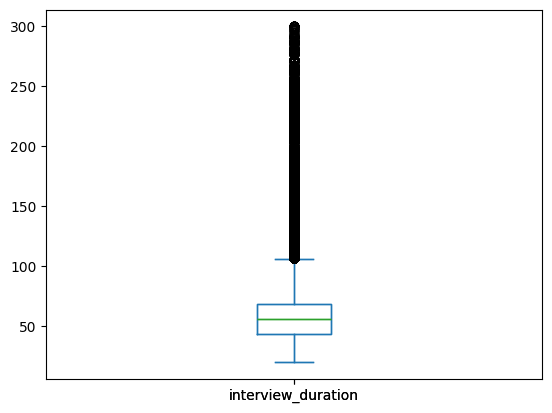


---Statistics---
Boxplot upper T: 106.0


count    70691.000000
mean        60.117837
std         27.917845
min         20.000000
25%         44.000000
50%         56.000000
75%         69.000000
max        300.000000
Name: interview_duration, dtype: float64

In [8]:
# overall, there is not much difference betwee subjects with interview_duration data 
# and participants not having interview_duration data
# let's identify which participants with interview_duration have valid answers

# first, let's get a general feel on the interview length
idurr = df.interview_duration.map(lambda val: np.nan if "-" in val else val).astype(float)
idurr.plot.box()
bp = idurr.plot.box(return_type="dict")
plt.show()

print()
print("---Statistics---")
print(f"Boxplot upper T: {bp['whiskers'][1].get_ydata()[1]}")
idurr.describe()

In [9]:
# in average, WVS takes 60 minutes to complete 
# let's filter out participants with completion times > 106min

# ignore nulls
mask = idurr[idurr > 100]
df = df.drop(index=mask.index)
print(f"Outliers dropped based on interview duration > 106min: {mask.shape[0]}")

# ps: we're simplifying here. We could refine the analysis by observing how
# the interview duration interacts with age, country, interview mode...
# for our purposes, this should do 

Outliers dropped based on interview duration > 106min: 3883


In [10]:
# let's dig deeper into alternative categories (answers < 0)
df_na_xpl = {}

# save the columns with missing data
for col in df.columns:
    na_counts = df[col][df[col].str.contains("-")].value_counts().to_dict()
    if col == "age":
        print(na_counts)

    if len(na_counts) > 0:
        df_na_xpl[col] = na_counts

# create a df with the missing data patterns
df_na_xpl = pd.DataFrame(df_na_xpl)
df_na_xpl = df_na_xpl.fillna(0)
# label missing values
df_na_xpl = df_na_xpl.rename(index={"-1": "Don't know",
                                    "-2": "No anwser",
                                    "-3": "Not applicable",
                                    "-4": "Not asked",
                                    "-5": "Missing"})
# sum the missing values and inspect  
df_na_xpl["total"] = df_na_xpl.sum(axis=1)
df_na_xpl.sort_values(by="total", ascending=False)

{'-5': 236, '-2': 196, '-1': 12}


,settlement,interview_duration,respint,intprivacy,sex,birth_year,age,immigrant,immigrant_mother,immigrant_father,...,contacted_government,encouraged_political_action,encouraged_voting,stays_politically_updated,signed_petitions_online,encouraged_political_action_online,organized_political_events,voted_locally,voted_nationally,total
Not asked,0.0,13863.0,6959.0,8758.0,0.0,0.0,0.0,0.0,2893,2893,...,0.0,3565.0,0.0,1098.0,2264.0,3462.0,3462.0,3129.0,3843.0,103159.0
Not applicable,0.0,6633.0,0.0,0.0,0.0,0.0,0.0,0.0,651,698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100054.0
Missing,86.0,2314.0,1448.0,0.0,48.0,1121.0,236.0,67.0,206,236,...,137.0,142.0,124.0,4426.0,4570.0,4338.0,4425.0,132.0,165.0,41866.0
No anwser,4.0,0.0,1414.0,2966.0,23.0,387.0,196.0,104.0,338,362,...,341.0,375.0,380.0,828.0,920.0,914.0,1068.0,289.0,357.0,40061.0
Don't know,1.0,0.0,0.0,0.0,2.0,6.0,12.0,36.0,171,234,...,1871.0,2115.0,1617.0,1591.0,2137.0,2044.0,1992.0,444.0,454.0,38255.0


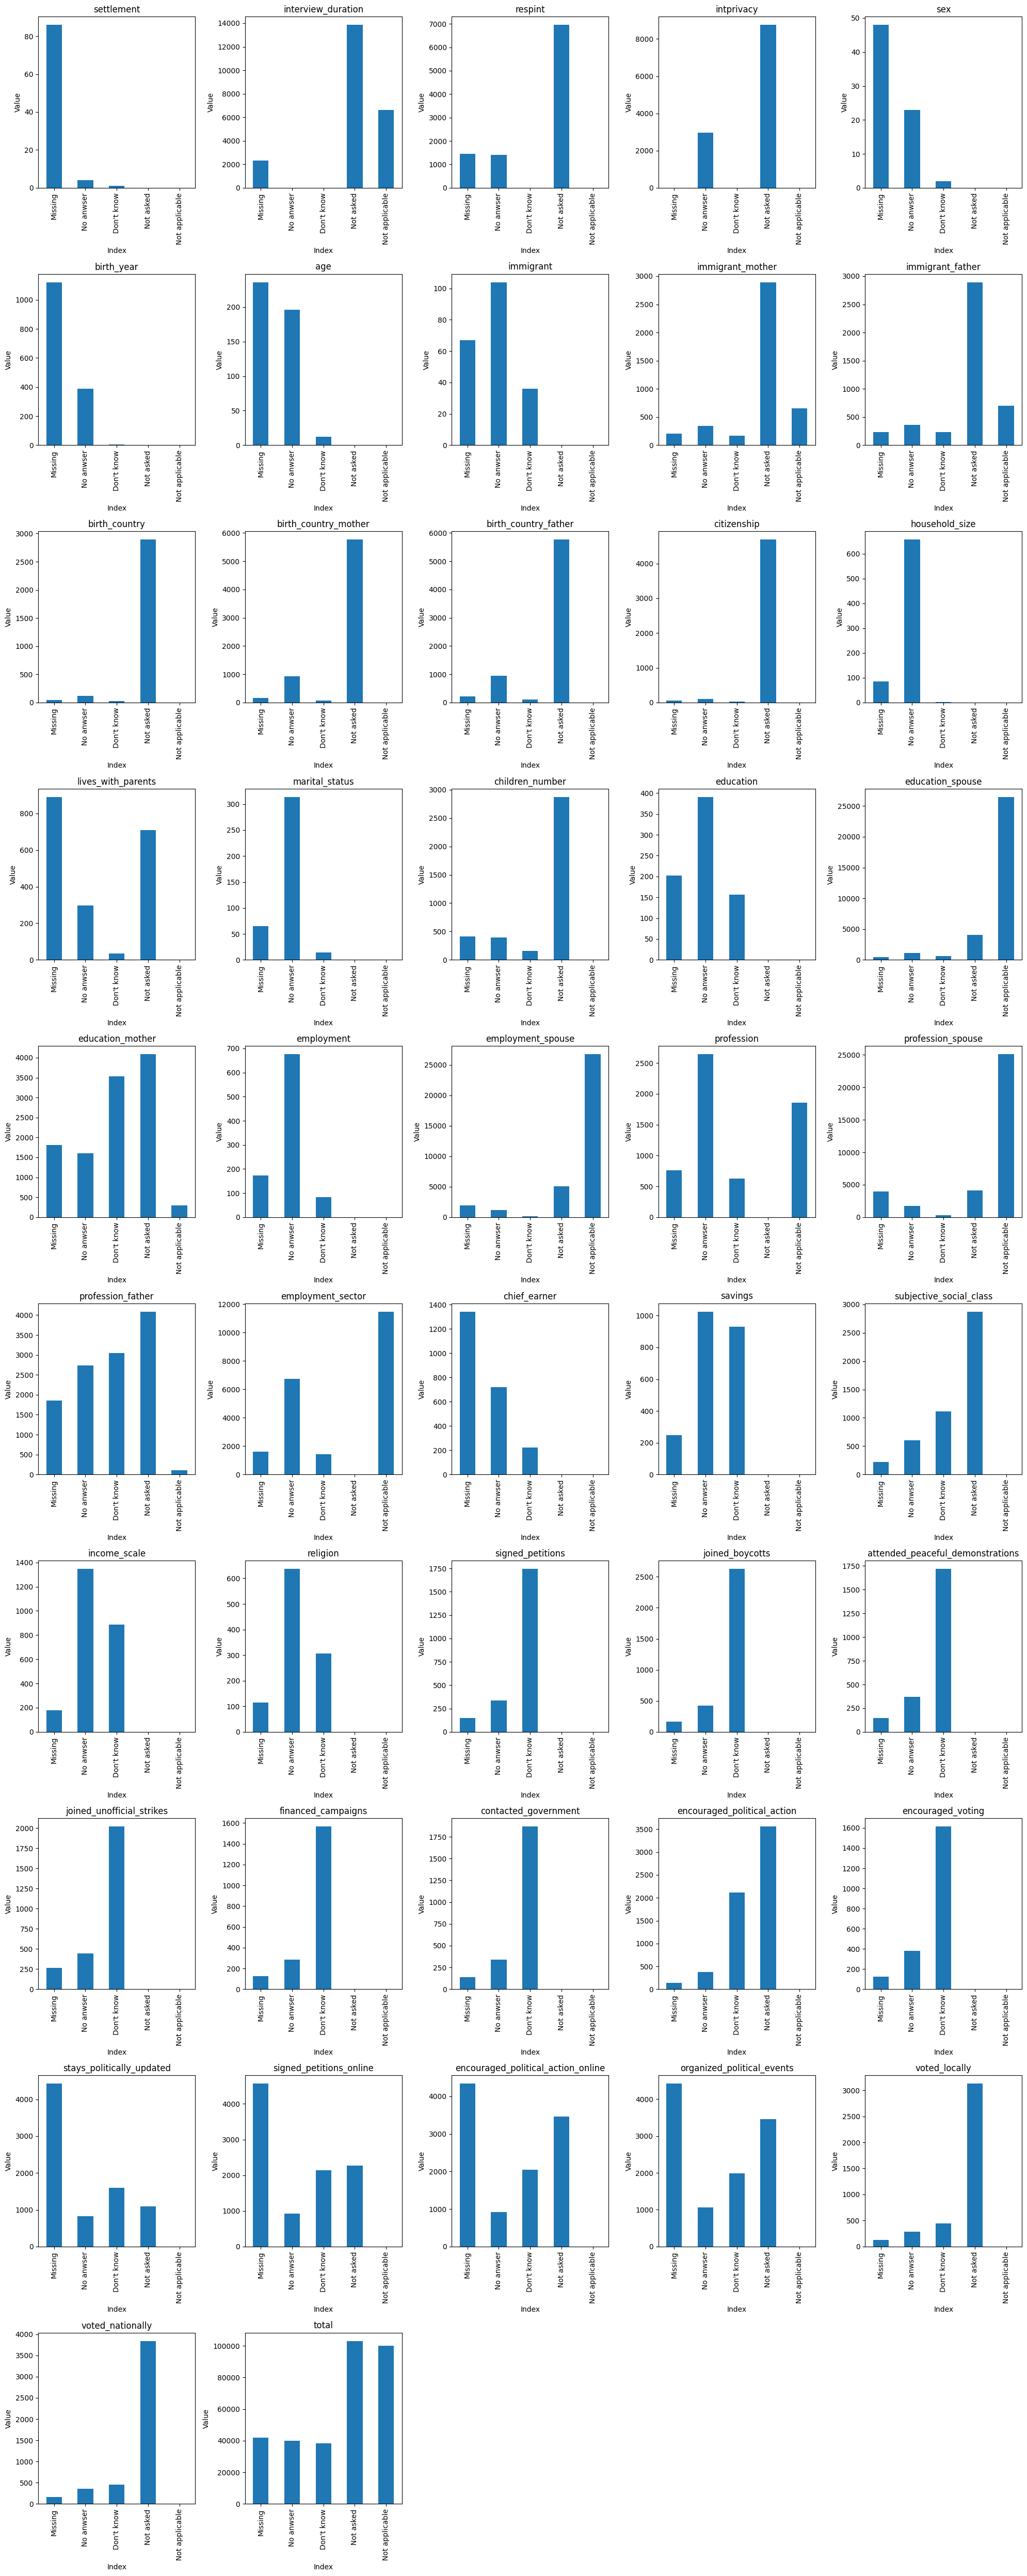

In [11]:
# plot nan categories
custom_functions.plot_na_cats(df_na_xpl)

In [12]:
# the plots above hint at different imputations techniques that we could apply to different variables
# variables with a low percent of missing data (<5%) and low-impact may be good candidatees for mean/median imputation
# variables with a high percent of missing data (>5%) may be good candidates for multiple imputation
# the remaining variables can be logically infered from available data and filled via wrangling

# key=column name, value1=imputation technique, value2=imputation step (imputation order matters)
imputation_guide = {"collection_year": ("-", 0),
                    "mode": ("-", 0),
                    "country": ("-", 0),
                    "weight": ("drop", 0.5), # weight is used to adujst values to the general population
                    "interview_duration": ("drop", 0.5), # has fulfilled its purpose 
                    "education_spouse": ("re-level, multiple_imputation", 0.7), # keep "not applicable" as a distinct category then multiple_imputation
                    "employment_spouse": ("re-level, multiple_imputation", 0.7), # idem
                    "immigrant_mother": ("re-level, multiple_imputation", 0.7), # idem
                    "immigrant_father": ("re-level, multiple_imputation", 0.7),  # idem
                    "employment_sector": ("re-level, multiple_imputation", 0.7), # idem
                    "profession_spouse": ("re-level, multiple_imputation", 0.7), # idem
                    "birth_country": ("inference", 0.9), # infer from country 
                    "birth_year": ("inference, simple_imputation", 0.9),  # collection_year - age then simple_imputation
                    "age": ("inference, simple_imputation", 0.9),
                    "settlement": ("simple_imputation", 1),
                    "sex": ("simple_imputation", 1),
                    "immigrant": ("simple_imputation", 1),
                    "household_size": ("simple_imputation", 1),
                    "lives_with_parents": ("simple_imputation", 1),
                    "marital_status": ("simple_imputation", 1),
                    "children_number": ("simple_imputation", 1),
                    "education": ("simple_imputation", 1),
                    "employment": ("simple_imputation", 1),
                    "chief_earner": ("simple_imputation", 1),
                    "savings": ("simple_imputation", 1),
                    "income_scale": ("simple_imputation", 1),
                    "religion": ("simple_imputation", 1),
                    "signed_petitions": ("simple_imputation", 1),
                    "joined_boycotts": ("simple_imputation", 1),
                    "attended_peaceful_demonstrations": ("simple_imputation", 1),
                    "joined_unofficial_strikes": ("simple_imputation", 1),
                    "financed_campaigns": ("simple_imputation", 1),
                    "contacted_government": ("simple_imputation", 1),
                    "encouraged_voting": ("simple_imputation", 1),
                    "voted_locally": ("simple_imputation", 1),
                    "voted_nationally": ("simple_imputation", 1),
                    "intprivacy": ("multiple_imputation", 3),
                    "respint": ("multiple_imputation", 3),
                    "citizenship": ("multiple_imputation", 3), # mixes legal and historical semantics
                    "birth_country_mother": ("multiple_imputation", 3), 
                    "birth_country_father": ("multiple_imputation", 3), 
                    "education_mother": ("multiple_imputation", 3), 
                    "profession": ("multiple_imputation", 3), 
                    "profession_father": ("multiple_imputation", 3), 
                    "subjective_social_class": ("multiple_imputation", 3), 
                    "encouraged_political_action": ("multiple_imputation", 3), 
                    "stays_politically_updated": ("multiple_imputation", 3), 
                    "signed_petitions_online": ("multiple_imputation", 3), 
                    "encouraged_political_action_online": ("multiple_imputation", 3), 
                    "organized_political_events": ("multiple_imputation", 3)}

# snapshot imputation strategies
df_na["imputation_technique"] = df_na.index.map(lambda x: imputation_guide.get(x, (None,))[0])
df_na["imputation_step"] = df_na.index.map(lambda x: imputation_guide.get(x, (None,None))[1]) 
df_na.sort_values(by="imputation_step")

# ps: regarding interview_duration we're going to make a leap of faith
# I'm not sure what happened methodologically to explain this amount of missing data
# we'll assume the 70% response rate justifies the missing interview_duration data


,na_count,na_percentage,imputation_technique,imputation_step
collection_year,0.0,0.00,-,0.0
country,0.0,0.00,-,0.0
mode,0.0,0.00,-,0.0
weight,0.0,0.00,drop,0.5
interview_duration,22810.0,24.40,drop,0.5
immigrant_mother,4440.0,4.75,"re-level, multiple_imputation",0.7
immigrant_father,4628.0,4.95,"re-level, multiple_imputation",0.7
profession_spouse,36692.0,39.24,"re-level, multiple_imputation",0.7
employment_spouse,36427.0,38.96,"re-level, multiple_imputation",0.7
education_spouse,34120.0,36.49,"re-level, multiple_imputation",0.7


In [13]:
# prepare df for further analysis
df_eda = df.copy()
# save weights for later (based on age, sex, education, region & aim to adjust to general population)
weights = df.weight.astype(float).to_dict()
# drop "noise"
df_eda = df_eda.drop(columns=["interview_duration", "weight"]) # step 0.5
# replace alternative responses with nulls
df_eda = df_eda.map(lambda val: np.nan if int(val) < 0 and int(val) != -3 else val) # keep "-3" (not applicable) as distinct category
# transform columns to numeric for further analysis
df_eda = df_eda.astype("Int32")
# smoothen special response options 
df_eda = df_eda.replace(-3, -1) # step 0.7
# rescale all items to go from 1 to n (some items start at 0 and we want 0 to = "not applicable")
for col in df_eda.columns:
    if 0 in df_eda[col].unique() and col != "children_number":
        df_eda[col] = df_eda.loc[df_eda[df_eda[col].notna()].index, col] + 1
# adjust the remaining "not applicable"
df_eda = df_eda.replace(-1, 0)
df_eda

,collection_year,country,mode,settlement,respint,intprivacy,sex,birth_year,age,immigrant,...,financed_campaigns,contacted_government,encouraged_political_action,encouraged_voting,stays_politically_updated,signed_petitions_online,encouraged_political_action_online,organized_political_events,voted_locally,voted_nationally
0,2018,20,2,1,1,1,2,1958,60,2,...,3,3,3,3,3,3,3,3,1,1
1,2018,20,2,2,1,1,1,1971,47,1,...,1,2,1,1,1,2,2,3,1,1
2,2018,20,2,2,1,1,1,1969,48,2,...,1,1,1,2,2,1,2,2,2,2
3,2018,20,2,2,2,1,2,1956,62,2,...,2,3,2,2,2,3,3,3,2,2
4,2018,20,2,2,2,1,1,1969,49,2,...,1,3,2,2,1,2,2,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94273,2022,909,1,5,1,1,2,1939,83,1,...,2,2,2,2,2,3,3,3,1,1
94274,2022,909,3,4,<NA>,<NA>,1,1987,34,1,...,3,2,3,3,3,2,3,3,3,3
94275,2022,909,1,5,1,1,2,2002,19,1,...,3,3,2,2,2,1,2,3,2,1
94276,2022,909,1,3,1,1,2,2003,19,1,...,1,3,2,3,2,2,2,3,2,4


In [59]:
# let's infer the na (step 0.9)
tot_rows = df_eda.shape[0]
display(df_na[df_na.imputation_technique.str.contains("inference")])
print("------------------------------------------------------------")

# infer birth_country from country
birth_country_before = df_na.loc["birth_country", "na_percentage"]
df_eda.birth_country = np.where(df_eda.birth_country.isna(), df_eda.country, df_eda.birth_country)
birth_country_after = round((df_eda.birth_country.isna().sum() / tot_rows) * 100, 2)
print(f"Inferring birth_country from country reduced na % by ({birth_country_before}% > {birth_country_after}%)")

# infer birth_year from collection_year - age
birth_year_before = df_na.loc["birth_year", "na_percentage"]
df_eda.birth_year = np.where(df_eda.birth_year.isna(), df_eda.collection_year - df_eda.age, df_eda.birth_year)
birth_year_after = round((df_eda.birth_year.isna().sum() / tot_rows) * 100, 2)
print(f"Inferring birth_year from collection_year - age reduced na % by ({birth_year_before}% > {birth_year_after}%)")

# infer age collection_year - birth_year
age_before = df_na.loc["age", "na_percentage"]
df_eda.age = np.where(df_eda.age.isna(), df_eda.collection_year - df_eda.birth_year, df_eda.age)
age_after = round((df_eda.age.isna().sum() / tot_rows) * 100, 2)
print(f"Inferring age from collection_date - birth_year reduced na % by ({age_before}% > {age_after}%)")


,na_count,na_percentage,imputation_technique,imputation_step
birth_country,3207.0,3.43,inference,0.9
birth_year,1559.0,1.67,"inference, simple_imputation",0.9
age,486.0,0.52,"inference, simple_imputation",0.9


------------------------------------------------------------
Inferring birth_country from country reduced na % by (3.43% > 0.0%)
Inferring birth_year from collection_year - age reduced na % by (1.67% > 0.49%)
Inferring age from collection_date - birth_year reduced na % by (0.52% > 0.49%)


In [60]:
# for simplicity purposes and because the remaining na % is rather low,
# we'll pre-fill the remaining na with medians 

# impute age
age_before = round((df_eda.age.isna().sum() / tot_rows) * 100, 2)
df_eda.age = df_eda.age.fillna(df_eda.age.median())
age_after = round(df_eda.age.isna().sum() / tot_rows, 2)
print(f"Imputing age reduced na % by ({age_before}% > {age_after}%)")

# further infer birth_year
birth_year_before = round((df_eda.birth_year.isna().sum() / tot_rows) * 100, 2)
df_eda.birth_year = df_eda.collection_year - df_eda.age
birth_year_after = round(df_eda.birth_year.isna().sum() / tot_rows, 2)

# we don't need collection_year anymore
df_eda = df_eda.drop(columns="collection_year")
print(f"Inferring birth_year reduced na % by ({birth_year_before}% > {birth_year_after}%)")

Imputing age reduced na % by (0.49% > 0.0%)
Inferring birth_year reduced na % by (0.49% > 0.0%)


In [61]:
# get datasets to avoid data leakage 
# we'll get our target later since it's composite variable with nan
df_fulltrain, df_train, df_val, df_test = custom_functions.generate_datasets(df_eda)
datasets = [df_fulltrain, df_train, df_val, df_test]

From 89618, rows generated:
    df_fulltrain: 71694
    df_train: 53770
    df_val: 17924
    df_test: 17924


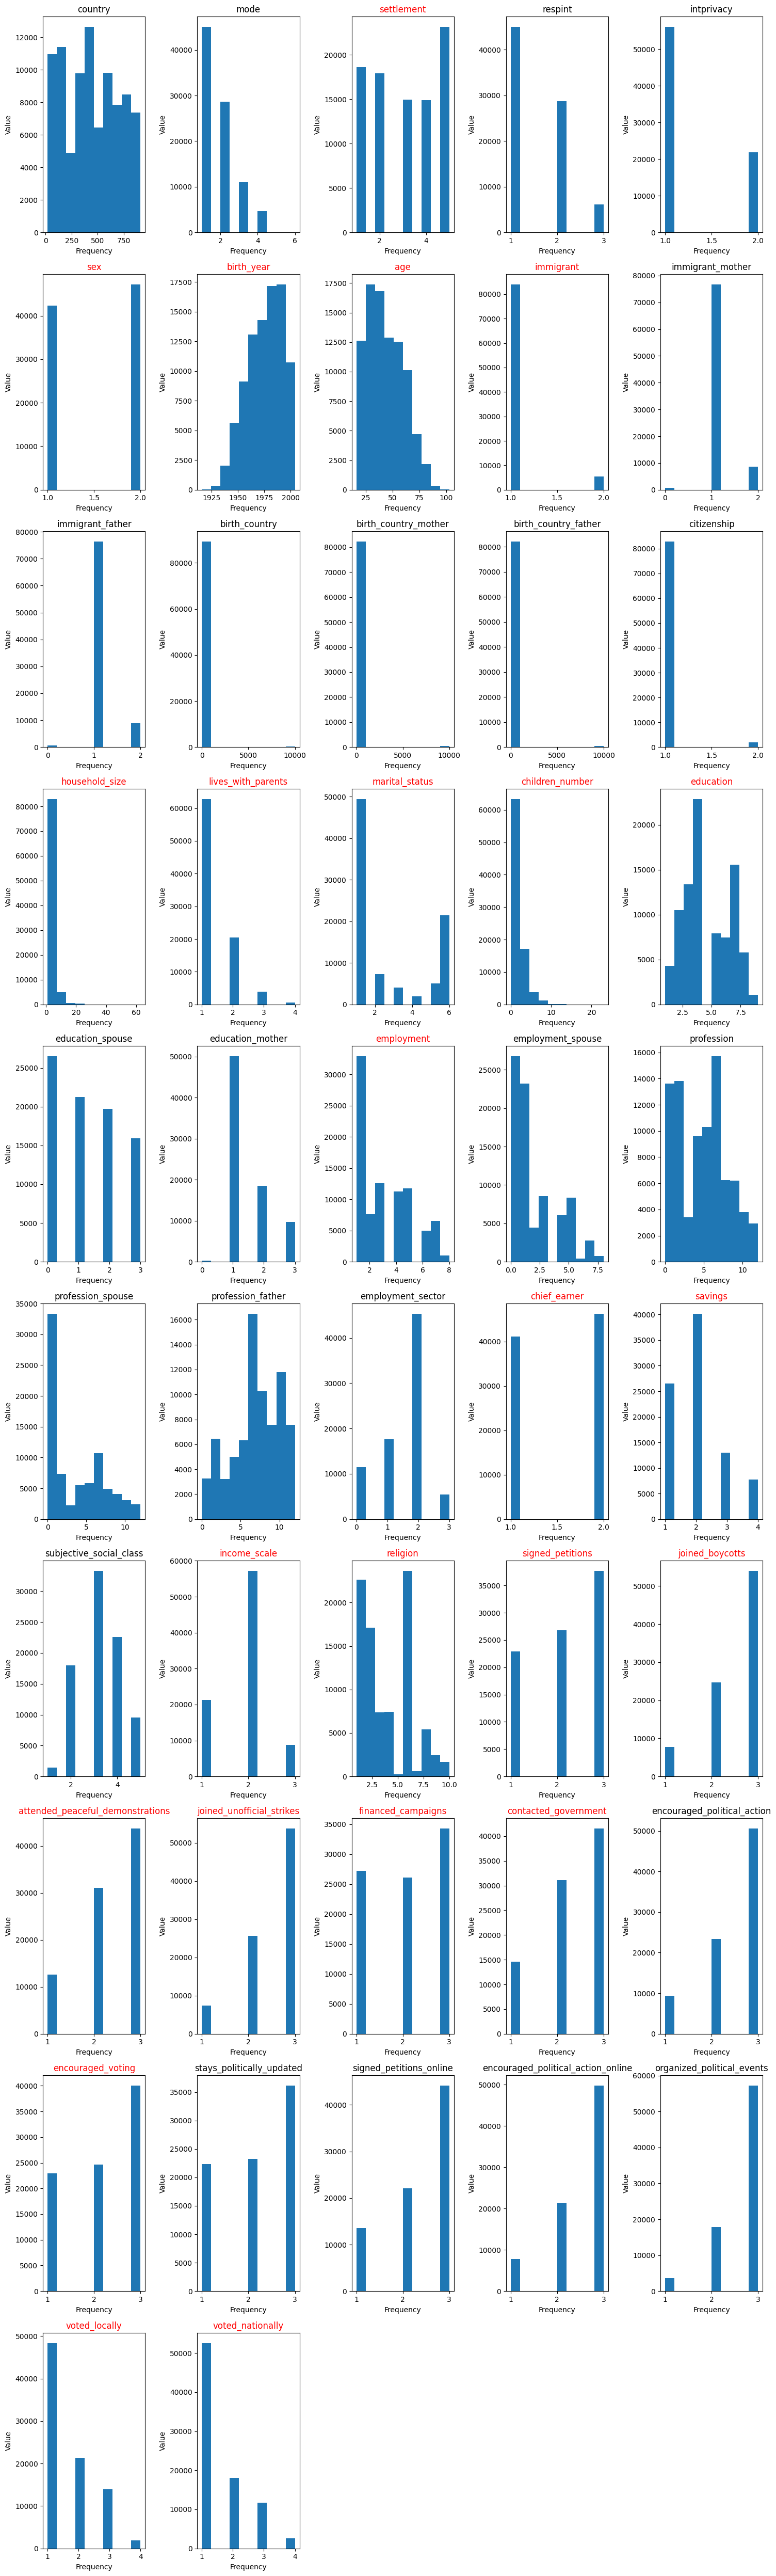

In [62]:
# for simple imputations, pick between mean, median or mode based on distributions
simple_imputation_columns = df_na[df_na.imputation_technique.str.contains("simple_imputation")].index

# plot variable distributions
custom_functions.plot_dist(df_eda, simple_imputation_columns)

In [63]:
# most of the data appears asymmetrical
# let's update our imputation strategies based on the graphs above
# mean, median and mode will be computed at the country level 
# for normal distributions we'll use the mean, for others we'll use the median/mode
update_imputations = {"settlement": "median_imputation",
                      "sex": "median_imputation",
                      "birth_year": "median_imputation",
                      "immigrant": "mode_imputation",
                      "household_size": "median_imputation",
                      "lives_with_parents": "median_imputation",
                      "marital_status": "median_imputation",
                      "children_number": "median_imputation",
                      "education": "mode_imputation", # we're using the mode because the distribution seems to be binomial 
                      "employment": "median_imputation",
                      "chief_earner": "mode_imputation",
                      "savings": "median_imputation", 
                      "income_scale": "median_imputation", 
                      "religion": "mode_imputation", 
                      "signed_petitions": "median_imputation", 
                      "joined_boycotts": "median_imputation", 
                      "attended_peaceful_demonstrations": "median_imputation", 
                      "joined_unofficial_strikes": "median_imputation", 
                      "financed_campaigns": "median_imputation", 
                      "contacted_government": "median_imputation", 
                      "encouraged_voting": "median_imputation", 
                      "voted_locally": "median_imputation", 
                      "voted_nationally": "median_imputation"}

# update imputation_guide
for var, val in imputation_guide.items():
    imputation_technique = val[0]
    imputation_guide[var] = [imputation_technique if var not in list(update_imputations.keys()) else update_imputations[var]][0]

# update imputation df
df_na = custom_functions.recompute_na(df_eda, imputation_guide)
df_na

,na_count,na_percentage,imputation_technique
profession_father,11734.0,13.09,multiple_imputation
intprivacy,11724.0,13.08,multiple_imputation
education_mother,11046.0,12.33,multiple_imputation
organized_political_events,10947.0,12.22,multiple_imputation
encouraged_political_action_online,10758.0,12.00,multiple_imputation
profession_spouse,10123.0,11.30,"re-level, multiple_imputation"
signed_petitions_online,9891.0,11.04,multiple_imputation
respint,9821.0,10.96,multiple_imputation
employment_sector,9767.0,10.90,"re-level, multiple_imputation"
employment_spouse,8321.0,9.28,"re-level, multiple_imputation"


In [64]:
# get the medians/modes
simple_imputation_map = {}
countries = list(df_fulltrain.country.unique())
simple_imputation_columns = df_na[(~df_na.imputation_technique.str.contains("multiple_imputation")) & 
                                  (~df_na.imputation_technique.str.contains("-"))].index
imputation_choice = {"median": lambda df: df.median(),
                     "mode": lambda df: df.mode()}

# parse countries
for country in countries:
    var_metrics = {}
    # target specific country
    df = df_fulltrain[df_fulltrain.country == country]

    for col in simple_imputation_columns:
        # get the target metric (median/mode)
        imputation_technique = df_na.loc[col, "imputation_technique"].split("_")[0]
        # get the desired median/mode for the current country
        imputation_value = df.groupby("country")[col].apply(imputation_choice[imputation_technique]).values[0]
        # if for whatever reason, there's no metric for that country, take the overall metric 
        if pd.isnull(imputation_value):
            imputation_value = df_fulltrain.groupby("country")[col].apply(imputation_choice[imputation_technique]).values[0]
        var_metrics[col] = (imputation_technique, round(imputation_value))
    
    simple_imputation_map[country] = var_metrics

c:\Users\andre\anaconda3\envs\mlzoomcamp\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\andre\anaconda3\envs\mlzoomcamp\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\andre\anaconda3\envs\mlzoomcamp\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\andre\anaconda3\envs\mlzoomcamp\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\andre\anaconda3\envs\mlzoomcamp\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\andre\anaconda3\envs\mlzoomcamp\lib\site-packages\numpy\lib\nanfunction

### Feature Engineering
____

In [65]:
# before continuing with the simple imputation, we need to verify the cardinality 
# not handeling cardinality & rare labels can lead to overfitting or invalid outputs 
cardinality = {}
for col in df_fulltrain.columns:
    cardinality[col] = len(df_fulltrain[col].unique())

cardinality = dict(sorted(cardinality.items(), key=lambda item: item[1], reverse=True))
cardinality

{'birth_country': 151,
 'birth_country_mother': 151,
 'birth_country_father': 150,
 'birth_year': 86,
 'age': 84,
 'country': 64,
 'household_size': 32,
 'children_number': 23,
 'profession': 14,
 'profession_spouse': 14,
 'profession_father': 14,
 'religion': 11,
 'education': 10,
 'employment_spouse': 10,
 'employment': 9,
 'marital_status': 7,
 'mode': 6,
 'settlement': 6,
 'subjective_social_class': 6,
 'lives_with_parents': 5,
 'education_spouse': 5,
 'education_mother': 5,
 'employment_sector': 5,
 'savings': 5,
 'voted_locally': 5,
 'voted_nationally': 5,
 'respint': 4,
 'immigrant_mother': 4,
 'immigrant_father': 4,
 'income_scale': 4,
 'signed_petitions': 4,
 'joined_boycotts': 4,
 'attended_peaceful_demonstrations': 4,
 'joined_unofficial_strikes': 4,
 'financed_campaigns': 4,
 'contacted_government': 4,
 'encouraged_political_action': 4,
 'encouraged_voting': 4,
 'stays_politically_updated': 4,
 'signed_petitions_online': 4,
 'encouraged_political_action_online': 4,
 'organi

In [66]:
# country of birth of the family may pose problems down the line
# let's assess cardinality accross our datasets
cardi_train_val = custom_functions.verify_cardinality(df_train, df_val)
cardi_train_test = custom_functions.verify_cardinality(df_train, df_test)

# ignore continuous or id variables
print("Categories present in df_train but not df_val:")
print(cardi_train_val)
print()
print("Categories present in df_train but not df_test:")
print(cardi_train_test)

Categories present in df_train but not df_val:
{'birth_country': 25, 'birth_country_mother': 22, 'birth_country_father': 22, 'birth_year': 4, 'children_number': 4, 'age': 3, 'household_size': 2}

Categories present in df_train but not df_test:
{'birth_country': 25, 'birth_country_father': 25, 'birth_country_mother': 23, 'children_number': 5, 'birth_year': 3, 'age': 2, 'household_size': -1}


In [67]:
# previous results indicate categorical imbalance in our data, let's handle it

# we can replace birth_country buy a binary "born in the country of living" (1=native, 0=another country)
# we explicit nan to avoid inadvertent filling 
df_eda.birth_country = np.select([df_eda.birth_country.isna(),
                                 df_eda.country == df_eda.birth_country.fillna(-99),
                                 df_eda.country != df_eda.birth_country.fillna(-99)],
                                 [df_eda.birth_country, 1, 0], default=df_eda.birth_country)
df_eda.birth_country_mother = np.select([df_eda.birth_country_mother.isna(),
                                         df_eda.country == df_eda.birth_country_mother.fillna(-99),
                                         df_eda.country != df_eda.birth_country_mother.fillna(-99)],
                                         [df_eda.birth_country_mother, 1, 0], default=df_eda.birth_country_mother)
df_eda.birth_country_father = np.select([df_eda.birth_country_father.isna(),
                                         df_eda.country == df_eda.birth_country_father.fillna(-99),
                                         df_eda.country != df_eda.birth_country_father.fillna(-99)],
                                         [df_eda.birth_country_father, 1, 0], default=df_eda.birth_country_father)

# we can replace birth_year by the generation
df_eda["generation"] = np.select([(1916 <= df_eda.birth_year) & (df_eda.birth_year <= 1945),
                                  (1946 <= df_eda.birth_year) & (df_eda.birth_year <= 1964),
                                  (1965 <= df_eda.birth_year) & (df_eda.birth_year <= 1980),
                                  (1981 <= df_eda.birth_year) & (df_eda.birth_year <= 1996),
                                  (1997 <= df_eda.birth_year) & (df_eda.birth_year <= 2012)],
                                 [0, # silent_gen
                                  1, # baby_boomers
                                  2, # gen_x 
                                  3, # gen_y
                                  4], default="WARNING") # gen_z

df_eda = df_eda.drop(columns="birth_year").astype("Int32")

# re-test class imbalance
df_fulltrain, df_train, df_val, df_test = custom_functions.generate_datasets(df_eda)
print()

# get cardinality
card_train_val = custom_functions.verify_cardinality(df_train, df_val)
card_train_test = custom_functions.verify_cardinality(df_train, df_test)

print("Categories present in df_train, but not df_val:")
print(card_train_val)
print()
print("Categories present in df_train, but not df_test:")
print(card_train_test)

From 89618, rows generated:
    df_fulltrain: 71694
    df_train: 53770
    df_val: 17924
    df_test: 17924

Categories present in df_train, but not df_val:
{'children_number': 4, 'age': 3, 'household_size': 2}

Categories present in df_train, but not df_test:
{'children_number': 5, 'age': 2, 'household_size': -1}


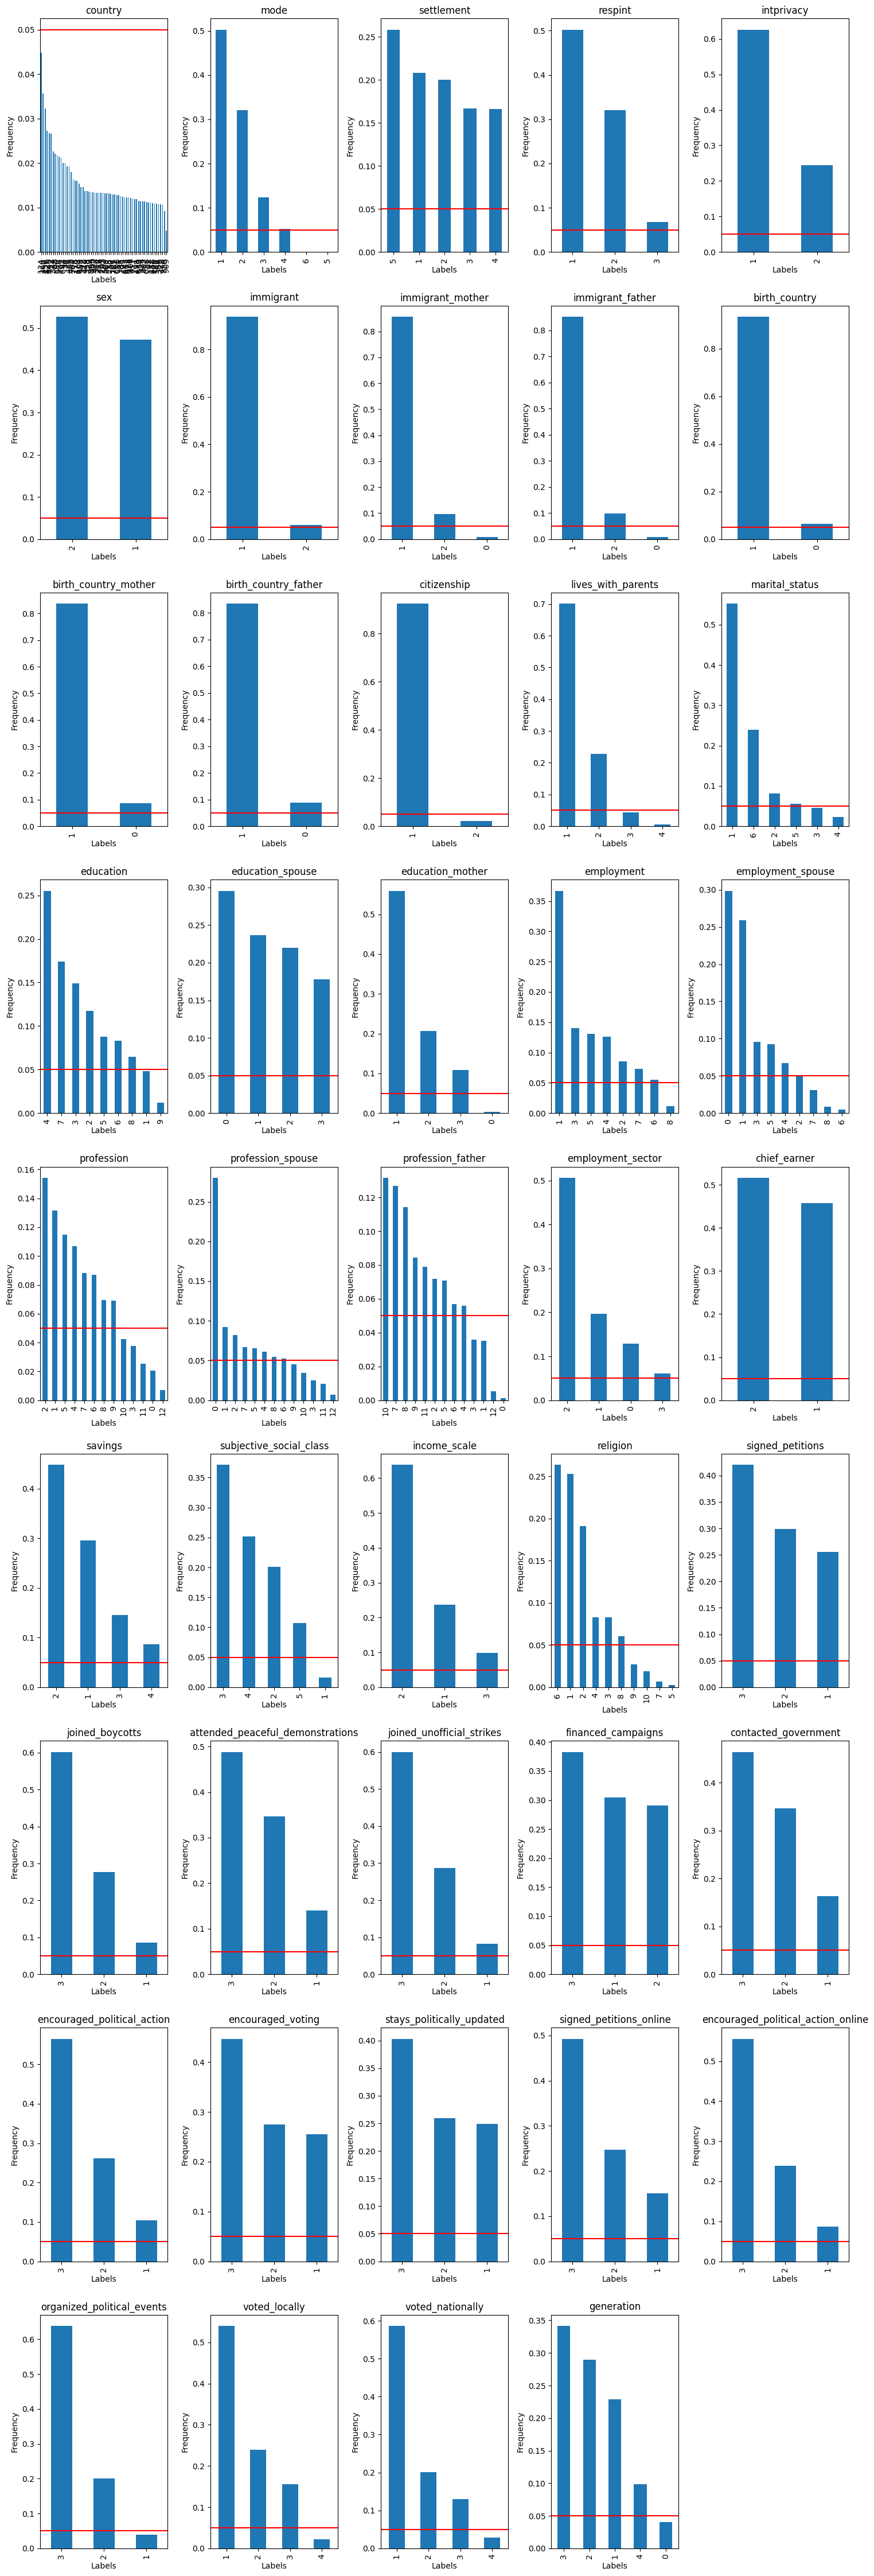

In [68]:
# now that we've fixed our class imbalance, let's inspect the rare labels
# isolate numerical columns 
num_cols = ["age", "household_size", "children_number"]

# pass only the categorical variables
custom_functions.plot_labels(df_eda.drop(columns=num_cols))

In [69]:
# several columns have items representing less than 5% of the data
# to avoid further complexifying things, we won't restructure ALL items 
# but we'll mainly use weigthing and wrangling
# for instance, changing 9 (rare label) to 8 in religion (10 levels) will discontinue the scale and pose problems later
# key=column name, value1=strategy, value2=strategy_step 
rare_labels = {"country": ("simple_weight", 2), # each country to n=1000
               "mode": ("re-label 6 and 5 to 4 (other)", 1), 
               "immigrant_mother": ("rare label 0 to nan", 0), # -1 = low frequency
               "immigrant_father": ("rare label 0 to nan", 0), # -1 = low frequency
               "citizenship": ("normalized_weighst", 3), # re-adjust under-representation (2=no)
               "lives_with_parents": ("re-label 3 and 4 to 2 (yes)", 1), 
               "marital_status": ("normalized_weights", 3),
               "education": ("skip", -1), # skipping because they are alreay computed in the initial weights
               "education_mother": ("rare label 0 to nan", 0), # -1 = low frequency
               "employment": ("rare label 8 (other) to nan", 0), # 8 = low frequency
               "employment_spouse": ("normalized_weights", 3), 
               "profession": ("re-label 0 to 1 (never had a job) & normalized_weights", 2.5), 
               "profession_spouse": ("normalized_weights", 3),
               "profession_father": ("re-label 0 to 1 (never had a job) & normalized_weights", 2.5), 
               "subjective_social_class": ("normalized_weights", 3),
               "religion": ("normalized_weights", 3), 
               "organized_political_events": ("normalized_weights", 3), 
               "voted_locally": ("normalized_weights", 3), 
               "voted_nationally": ("normalized_weights", 3), 
               "generation": ("normalized_weights", 3) }

df_labels = pd.DataFrame(rare_labels).T
df_labels.columns = ["strategy", "strategy_step"]
df_labels = df_labels.sort_values("strategy_step")
df_labels

,strategy,strategy_step
education,skip,-1
employment,rare label 8 (other) to nan,0
immigrant_mother,rare label 0 to nan,0
immigrant_father,rare label 0 to nan,0
education_mother,rare label 0 to nan,0
mode,re-label 6 and 5 to 4 (other),1
lives_with_parents,re-label 3 and 4 to 2 (yes),1
country,simple_weight,2
profession,re-label 0 to 1 (never had a job) & normalized...,2.5
profession_father,re-label 0 to 1 (never had a job) & normalized...,2.5


In [70]:
# let's replace very rare lables by nan
targets = df_labels[df_labels.strategy.str.contains("rare label")].index
datasets = [df_fulltrain, df_train, df_val, df_test]

for target in targets:
    # extract the label from the strategy
    label = re.findall("[-+]?\d+", df_labels.loc[target, "strategy"])[0]
    level = int(label)

    # replace the values
    for ds in datasets:
        ds[target] = ds[target].replace(level, np.nan)

    print(f"{target}: replaced {label} by nan")

employment: replaced 8 by nan
immigrant_mother: replaced 0 by nan
immigrant_father: replaced 0 by nan
education_mother: replaced 0 by nan


In [71]:
# let's re-lable rare labels under new significant labels
targets = df_labels[df_labels.strategy.str.contains("re-label")].index

for target in targets:
    # extract the labels from the strategy
    labels = re.findall("[-+]?\d+", df_labels.loc[target, "strategy"])
    # convert labels to int
    labels = [eval(i) for i in labels]
    # split original labels and target labels 
    target_label = labels[-1]
    labels.pop()

    # re-label
    for ds in datasets:
        ds[target] = ds[target].replace(labels, target_label)
    
    print(f"{target}: re-labeled {labels} by {target_label}")

mode: re-labeled [6, 5] by 4
lives_with_parents: re-labeled [3, 4] by 2
profession: re-labeled [0] by 1
profession_father: re-labeled [0] by 1


In [72]:
# before assigning weights, let's finish simple imputations
for country, columns in simple_imputation_map.items():
    for col, simp_imp in columns.items():
        # get imputation value 
        val = simp_imp[1]
        # fill nan values with mean/median by country and target columns 
        for ds in datasets:
            ds.loc[ds[(ds.country == country) & (ds[col].isna())].index, col] = val

# double check the process for simple imputations
df_na = custom_functions.recompute_na(pd.concat(datasets[1:]), imputation_guide) # combine train, val and test sets 
df_na

,na_count,na_percentage,imputation_technique
profession_father,11734.0,13.09,multiple_imputation
intprivacy,11724.0,13.08,multiple_imputation
education_mother,11341.0,12.65,multiple_imputation
organized_political_events,10947.0,12.22,multiple_imputation
encouraged_political_action_online,10758.0,12.00,multiple_imputation
profession_spouse,10123.0,11.30,"re-level, multiple_imputation"
signed_petitions_online,9891.0,11.04,multiple_imputation
respint,9821.0,10.96,multiple_imputation
employment_sector,9767.0,10.90,"re-level, multiple_imputation"
employment_spouse,8321.0,9.28,"re-level, multiple_imputation"


### FEATURE ENGINEERING: POST-IMPUTATION
________

In [73]:
# # the results of the this cell have been save in the "imputed_data" folder
# # and has been commented out as time saver
#############################commented for parsimony#############################
# # handle multiple imputations
# # here, we'll use missForest
# imputed_ds = []

# imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=23),
#                            initial_strategy="mean",
#                            max_iter=10,
#                            random_state=23)

# # train
# imputer.fit(df_fulltrain)

# # replace missing values
# for ds in datasets:
#     dst = imputer.transform(ds)
#     ds = pd.DataFrame(dst, columns=ds.columns)
#     ds = ds.astype(int)
#     imputed_ds.append(ds)
#############################commented for parsimony#############################

#############################commented for parsimony#############################
# # make sure the imputer didn't hallucinate levels 
# target_columns = list(df_na[df_na.imputation_technique.str.contains("multiple_imputation")].index)


# for col in target_columns:
#     # iterate over original and imputed dataframes
#     for df, dfi in zip(datasets, imputed_ds):
#         # get unique categories 
#         df_uniq = sorted(list(df[col].dropna().unique()))
#         dfi_uniq = sorted(list(dfi[col].unique()))
#         # flag abherations
#         if len(df_uniq) != len(dfi_uniq):
#             print(f"Found inexistant levels for {col}: {get_objname(df)}={df_uniq} | imputed={dfi_uniq}")
#############################commented for parsimony#############################

#############################commented for parsimony#############################
# # select the imputed sets
# for i, ds in enumerate(datasets):
#     # the imputation doesn't conserve index order, so we correct that
#     imputed_ds[i].index = datasets[i].index
#     datasets[i] = imputed_ds[i]

# df_fulltrain, df_train, df_val, df_test = datasets
#############################commented for parsimony#############################

#############################commented for parsimony#############################
# # save imputed data 
df_names = ["df_fulltrain.parquet", "df_train.parquet", "df_val.parquet", "df_test.parquet"]

# for i, ds in enumerate(datasets):
#     # for some reason, indexes are not conserved on ulterior reads, thus we save them explictily
#     ds.to_parquet(fr"imputed_data\{df_names[i]}")

# # save imputation guide
# with open('imputation_guide.json', 'w') as file:
#     json.dump(imputation_guide, file)
# # save original wieghts
# with open("original_weights.json", "w") as file:
#     json.dump(weights, file)
# # save label states to parquet
# df_labels.to_parquet("df_labels.parquet")
#############################commented for parsimony#############################

#############################commented for parsimony#############################
# # check that imputations haven't distorted variables too much
# def check_distorsions(dfs_original: list, dfs_imputed: list, columns: list) -> None:
#     """Compare distributions of original variables and imputed ones"""
#     nvars = len(columns)
#     ncols = 5
#     nrows = ceil(nvars / ncols)

#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
#     axes = axes.flatten()

#     for i, col in enumerate(columns):
#         ax = axes[i]
#         for dfo, dfi in zip(dfs_original, dfs_imputed):
#             sns.kdeplot(dfo[col], label=get_objname(dfo), ax=ax)
#             sns.kdeplot(dfi[col], label="imputed", ax=ax)
        
#         ax.set_title(f"Distribution for {col}")
#         ax.legend()

#     for j in range (i + 1, len(axes)):
#         fig.delaxes(axes[j])
    
#     plt.tight_layout()
#     plt.show()

# check_distorsions([datasets[0]], [imputed_ds[0]], target_columns)
#############################commented for parsimony#############################

# load imputed data
datasets = []
path = "imputed_data"

for df_name in df_names:
    if df_name in os.listdir(path):
        file_path = fr"{path}\{df_name}"
        df = pd.read_parquet(file_path)
        datasets.append(df)

df_fulltrain, df_train, df_val, df_test = datasets

# load_imputation guide
with open('misc/imputation_guide.json', 'r') as file:
    imputation_guide = json.load(file)

# load original weights
with open("misc/original_weights.json", "r") as file:
    weights = json.load(file)

# read label_states
df_labels = pd.read_parquet("misc/df_labels.parquet")

In [74]:
# previous imputation results suggest overfitting for some variables
# because of time constraints, we will accept the results as such and proceed with operations

# double_check nan one last time
df_na = custom_functions.recompute_na(pd.concat(datasets[1:]), imputation_guide) 
df_na

,na_count,na_percentage,imputation_technique
country,0.0,0.0,-
joined_unofficial_strikes,0.0,0.0,-
employment_sector,0.0,0.0,-
chief_earner,0.0,0.0,-
savings,0.0,0.0,-
subjective_social_class,0.0,0.0,-
income_scale,0.0,0.0,-
religion,0.0,0.0,-
signed_petitions,0.0,0.0,-
joined_boycotts,0.0,0.0,-


In [75]:
# get columns to be of weighted
targets = df_labels[df_labels.strategy.str.contains("normalized_weights")].index
# get composite, normalized weights for training sets 
wdf_fulltrain = custom_functions.format_weights(df_fulltrain, targets, weights)
wdf_train = custom_functions.format_weights(df_train, targets, weights)

-----Distribution of Numerical Variables-----


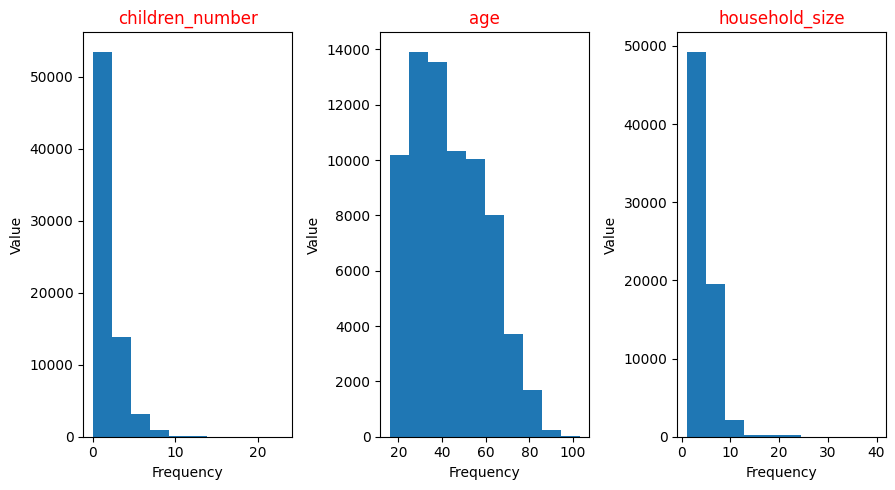

-----Statistics of Numerical Variables-----


,children_number,age,household_size
count,71694.000000,71694.000000,71694.000000
mean,1.727020,43.223715,3.969091
std,1.681138,16.437078,2.534802
min,0.000000,16.000000,1.000000
25%,0.000000,30.000000,2.000000
50%,2.000000,41.000000,4.000000
75%,3.000000,55.000000,5.000000
max,23.000000,103.000000,40.000000


-----Most Frequent Categories of Numerical Variables-----
children_number
0    0.285115
2    0.257107
1    0.204117
3    0.132298
4    0.061860
Name: count, dtype: float64
household_size
4    0.212152
2    0.193754
3    0.183502
5    0.132215
1    0.097735
Name: count, dtype: float64


In [76]:
# let's discretize continuous variables
num_vars = ["children_number", "age", "household_size"]
print("-----Distribution of Numerical Variables-----")
custom_functions.plot_dist(df_fulltrain[num_vars], num_vars)

# peek at the stats
print("-----Statistics of Numerical Variables-----")
display(df_fulltrain[num_vars].describe())

# identify most frequent categories
print("-----Most Frequent Categories of Numerical Variables-----")
print((df_fulltrain.children_number.value_counts() / df_fulltrain.shape[0])[:5])
print((df_fulltrain.household_size.value_counts() / df_fulltrain.shape[0])[:5])

In [77]:
# discretize
for i, ds in enumerate(datasets):
    # if subjects have 4 or more children then 4 (var becomes categorical)
    ds["children_number"] = ds["children_number"].map(lambda val: 4 if val >= 4 else val)
    # if the family size of the subjects is 5 or more then 5 (var becomes categorical)
    ds["household_size"] = ds["household_size"].map(lambda val: 5 if val >= 5 else val)
    # since we have generation, age seems to be redundant
    ds = ds.drop(columns="age")
    datasets[i] = ds

In [78]:
# time to wrangle our dependent variable
# political engagement is decomposed into several variables
# let's combine them into a signle dependent variable called "political_engagement"
dv = ["signed_petitions", "joined_boycotts", "attended_peaceful_demonstrations",
      "joined_unofficial_strikes", "financed_campaigns", "contacted_government",
      "encouraged_political_action", "encouraged_voting", "stays_politically_updated",
      "signed_petitions_online", "encouraged_political_action_online", "organized_political_events",
      "voted_locally", "voted_nationally"]

for i, ds in enumerate(datasets):
    # combine dependent variables
    ds["political_engagement"] = round(ds[dv].sum(axis=1) / len(dv)).astype("Int32")
    # keep only the composite dv
    ds = ds.drop(columns=dv)
    datasets[i] = ds

df_fulltrain, df_train, df_val, df_test = datasets

In [79]:
# inspect it's distribution
print(df_fulltrain.political_engagement.value_counts() / len(df_fulltrain))

political_engagement
2    0.612994
3    0.325704
1    0.061302
Name: count, dtype: Float64


In [80]:
# at first glance, most people seem to be moderatly engaged in politics (1=high engagement, 3=low engagement)
# as a reminder, our objective is to detect and re-engage politically disengaged people
# to avoid delving deeper into weighting, perhaps we'll gain by binarizing our target (0=engaged, 1=disengaged)
# this will simplify our model and somewhat attenuate the imbalance in our target 
pol_eng_map = {1: 0,
               2: 0,
               3: 1}

for i, ds in enumerate(datasets):
    ds["political_engagement"] = ds["political_engagement"].map(pol_eng_map)
    datasets[i] = ds

df_fulltrain, df_train, df_val, df_test = datasets
print(df_fulltrain.political_engagement.value_counts() / len(df_fulltrain))

political_engagement
0    0.674296
1    0.325704
Name: count, dtype: float64


In [81]:
# get the final train sets and targets 
dvs = []

for i, ds in enumerate(datasets):
    dvs.append(ds.political_engagement.values)
    ds = ds.drop(columns="political_engagement")
    datasets[i] = ds

x_fulltrain, x_train, x_val, x_test = datasets
y_fulltrain, y_train, y_val, y_test = dvs

In [82]:
# let's flag ordinal and nominal columns
ordinal = ["respint", "household_size", "children_number", "education", 
           "education_spouse", "education_mother", "subjective_social_class",
           "income_scale", "generation"]
nominal = ["country", "mode", "settlement", "intprivacy",
           "sex", "immigrant", "immigrant_mother", "immigrant_father", 
           "birth_country", "birth_country_mother", "birth_country_father", 
           "citizenship", "lives_with_parents", "marital_status", "employment", 
           "employment_spouse", "profession", "profession_spouse", 
           "profession_father", "employment_sector", "chief_earner", "savings",
           "religion"]

dummy_datasets = []

for ds in datasets:
    ds[nominal] = ds[nominal].astype(str)
    ds_dict = ds.to_dict(orient="records")
    dummy_datasets.append(ds_dict)

In [83]:
# dummy encode nominal variables.
dv = DictVectorizer(sparse=False)
x_fulltrain = dv.fit_transform(dummy_datasets[0])
x_train = dv.transform(dummy_datasets[1])
x_val = dv.transform(dummy_datasets[2])
x_test = dv.transform(dummy_datasets[3])

features = dv.get_feature_names_out().tolist()

### TRAINING
___

In [84]:
# given the complexity of the dataset, we'll start by implementing a XGB model
xtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features, weight=wdf_train)
xval = xgb.DMatrix(x_val, label=y_val, feature_names=features)

In [85]:
%%capture output
watchlist = [(xtrain, "train"), (xval, "val")]

# set params
xgb_params = {"eta": 1,
              "max_depth": 5, 
              "min_child_weight": 10,
              "objective": "binary:logistic",
              "nthread": -1,
              "seed": 23,
              "verbosity": 1,
              "eval_metric": "auc",
              "scale_pos_weight": 1, # correct for target inbalance
              "alpha": 10 # we want to eliminte unhelpful features
              }

# train
xgb_model = xgb.train(xgb_params, xtrain, evals=watchlist, verbose_eval=5, num_boost_round=100)

In [86]:
# # let's get a first accuracy score
ypred = xgb_model.predict(xval)
roc_auc_score(y_val, ypred)

0.7628509196228651

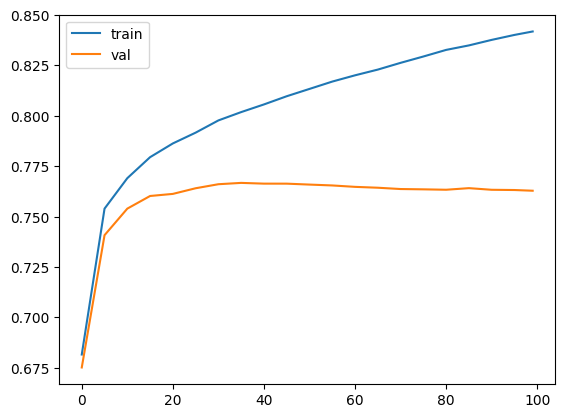

In [87]:
# inspect outputs
df_scores = custom_functions.plot_xgb_output(output)

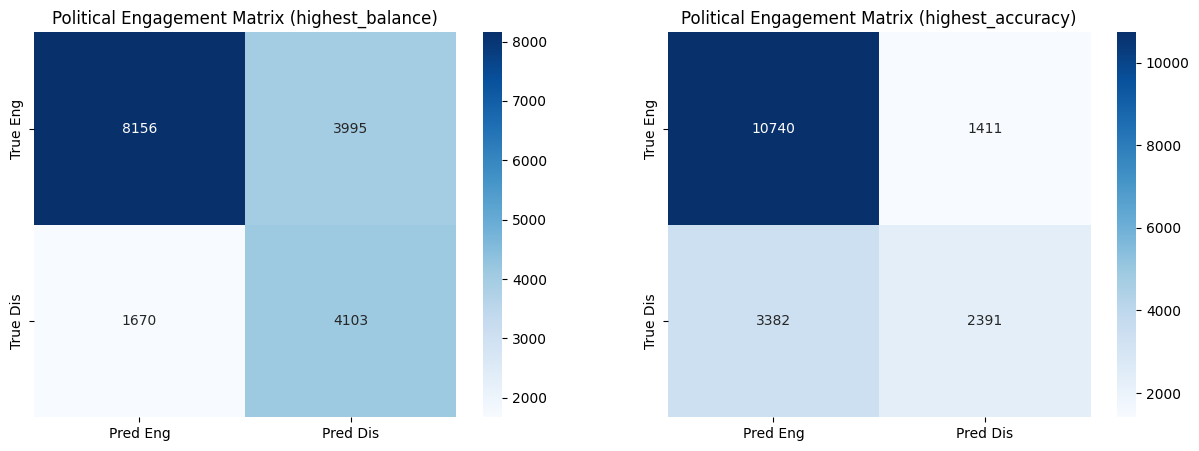

,threshold,accuracy_perc,precision_perc,sensitivity_perc
highest_balance,0.316,0.683943,51,71
highest_accuracy,0.536,0.733000,63,41


In [88]:
# the following function will find the best threshold based on 2 selected indexes
# - youden index (best TPR - FPR rate)
# - highest accuracy 
custom_functions.optimize_cm(y_val, ypred)

### TUNING
___

In [89]:
# # this tunning cell has been commented out as time saver
# # the comment below will comment the optimized matrices above 
# #############################commented for parsimony##############################
# # these results are mediocre given that we want to re-engage politically disengaged people
# # an ideal application would discrimnate well between the 2 classes 
# # as to avoid wasting ressources for people who are already highly or moderatly engaged in politics
# # let's try to improve the classfication
# param_headers = ["eta", "max_depth", "min_child_weight", "scale_pos_weight", 
#                  "alpha", "weights_on", "train_auc", "val_auc", "train_loss", "val_loss"]
# param_scores = []

# param_weights = [None, wdf_train]
# param_eta = [0.01, 0.1, 1]
# param_depth = [10, 25, 50, 100]
# param_child = [10, 25, 50, 100]
# param_spw = [0, 10, 25, 50]
# param_alpha = [0, 25, 50, 100]
# model = 0

# # try:
# for w in param_weights:
#     weights_on = 0

#     xtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features, weight=w)

#     if w is not None:
#         weights_on = 1

#     for eta in param_eta:
#         for depth in param_depth:
#             for child in param_child:
#                 for spw in param_spw:
#                     for alpha in param_alpha:
#                         model += 1

#                         # set params
#                         xgb_params = {"eta": eta,
#                                         "max_depth": depth, 
#                                         "min_child_weight": child,
#                                         "objective": "binary:logistic",
#                                         "nthread": -1,
#                                         "seed": 23,
#                                         "verbosity": 1,
#                                         # "scale_pos_weight": spw,
#                                         "alpha": alpha}

#                         # train
#                         xgb_model = xgb.train(xgb_params, xtrain, num_boost_round=200)

#                         # # get predictions
#                         # ytrain_pred = xgb_model.predict(xtrain)
#                         # yval_pred = xgb_model.predict(xval)
#                         # # get auc
#                         # train_auc = roc_auc_score(y_train, ytrain_pred)
#                         # val_auc = roc_auc_score(y_val, yval_pred)
#                         # # get loss
#                         # train_log_loss = log_loss(y_train, ytrain_pred)
#                         # val_log_loss = log_loss(y_val, yval_pred)

#                         param_scores.append((eta, depth, child, spw, alpha, weights_on, 
#                                             train_auc, val_auc, train_log_loss, val_log_loss))
                        
#                         print(f"model: {model} - weights_on: {weights_on} - eta: {eta} - depth: {depth} - leaf: {child} - spw: {spw} - alpha: {alpha}")
                                
# #                             raise Exception
# # except:
# #     pass

# # format results
# tuning_results = pd.DataFrame(param_scores, columns=param_headers)
# tuning_results
# #############################commented for parsimony##############################

In [90]:
#############################commented for parsimony#############################
# # below was a - failed - attempt to improve model performance via resampeling
# train_res = datasets[1].copy()
# tartrain_res = dvs[1].copy()

# xtrain_res, ytrain_res = SMOTENC(random_state=23, categorical_features=nominal).fit_resample(train_res, tartrain_res)
# xtrain_res = xtrain_res[nominal].astype(str)
# xtrainres_dict = xtrain_res.to_dict(orient="records")
# xtrain_tres = dv.transform(xtrainres_dict)
#############################commented for parsimony#############################

#############################commented for parsimony#############################
# # try random forests
# param_headers = ["n_estimators", "max_depth", "min_samples_leaf", "weights_on", "train_auc", "val_auc", "train_loss", "val_loss"]
# param_scores = []

# param_weights = [None, wdf_train]
# param_estimators = [10, 50, 100, 200]
# param_depth = [10, 25, 50, 100]
# param_leaf = [10, 25, 50, 100]
# model = 0

# for w in param_weights:
#     weights_on = 0

#     xtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features, weight=w)

#     if w is not None:
#         weights_on = 1

#     for estimator in param_estimators:
#         for depth in param_depth:
#             for leaf in param_leaf:
#                 model += 1

#                 rf = RandomForestClassifier(n_estimators=estimator,
#                                             max_depth=depth,
#                                             min_samples_leaf=leaf,
#                                             random_state=23,
#                                             n_jobs=-1)
                
#                 rf.fit(x_train, y_train)

#                 # get predictions
#                 ytrain_pred = rf.predict(x_train)
#                 yval_pred = rf.predict(x_val)
#                 # get auc
#                 train_auc = roc_auc_score(y_train, ytrain_pred)
#                 val_auc = roc_auc_score(y_val, yval_pred)
#                 # get loss
#                 train_log_loss = log_loss(y_train, ytrain_pred)
#                 val_log_loss = log_loss(y_val, yval_pred)

#                 param_scores.append((estimator, depth, leaf, weights_on, 
#                                     train_auc, val_auc, train_log_loss, val_log_loss))
                
#                 print(f"model: {model} - weights_on: {weights_on} - nestimators: {estimator} - depth: {depth} - leaf: {leaf}")

# rf_results = pd.DataFrame(param_scores, columns=param_headers)
# rf_results, top_rf = wrangle_tuning_results(rf_results)
#############################commented for parsimony#############################

#############################commented for parsimony#############################
# # try logistic regression
# logreg = LogisticRegression(solver="saga", penalty="elasticnet", class_weight={1: 1, 0: 2}, l1_ratio=0.8)
# logreg.fit(x_train, y_train)

# ypred = logreg.predict_proba(x_val)[:, 1]
# roc_auc_score(y_val, ypred)
#############################commented for parsimony#############################

### Model Selection
___

In [91]:
# read tuning results
tuning_results = pd.read_parquet("misc/tuning_results.parquet")
tuning_results

,eta,max_depth,min_child_weight,scale_pos_weight,alpha,weights_on,train_auc,val_auc,train_loss,val_loss
0,0.01,10,10,0,0,0,0.500000,0.500000,1.359777,1.339932
1,0.01,10,10,0,25,0,0.500000,0.500000,1.348376,1.328708
2,0.01,10,10,0,50,0,0.500000,0.500000,1.337383,1.317887
3,0.01,10,10,0,100,0,0.500000,0.500000,1.316520,1.297350
4,0.01,10,10,10,0,0,0.803885,0.765508,0.953672,0.991816
...,...,...,...,...,...,...,...,...,...,...
1531,1.00,100,100,25,100,1,0.863779,0.754755,1.096518,1.255051
1532,1.00,100,100,50,0,1,0.988782,0.728631,0.352565,1.162145
1533,1.00,100,100,50,25,1,0.967813,0.742743,0.652815,1.156825
1534,1.00,100,100,50,50,1,0.940042,0.746691,0.881940,1.261172


In [92]:
# sneak a peek at the results 
tuning_results.describe()

,eta,max_depth,min_child_weight,scale_pos_weight,alpha,weights_on,train_auc,val_auc,train_loss,val_loss
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000
mean,0.370000,46.250000,46.250000,21.250000,43.750000,0.500000,0.782194,0.694457,1.188537,1.359101
std,0.447136,34.175252,34.175252,18.839283,36.987541,0.500163,0.177430,0.113110,0.601309,0.431477
min,0.010000,10.000000,10.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.013776,0.656578
25%,0.010000,21.250000,21.250000,7.500000,18.750000,0.000000,0.690723,0.662741,0.800413,1.021739
50%,0.100000,37.500000,37.500000,17.500000,37.500000,0.500000,0.816854,0.754503,1.200100,1.298460
75%,1.000000,62.500000,62.500000,31.250000,62.500000,1.000000,0.927307,0.770392,1.546898,1.614983
max,1.000000,100.000000,100.000000,50.000000,100.000000,1.000000,1.000000,0.779459,2.962870,2.919108


In [93]:
# let's see which models performed best accross accuracy and loss
# we'll get the top 10 on these metrics and an aggregated score
tuning_results, top_models = custom_functions.wrangle_tuning_results(tuning_results)
display(top_models)
tuning_results.describe()

,eta,max_depth,min_child_weight,scale_pos_weight,alpha,weights_on,train_auc,val_auc,train_loss,val_loss,auc_diff,loss_diff,top_10_val_auc,top_10_val_loss,top_10_auc_diff,top_10_loss_diff,top_models
55,0.01,10,100,10,100,0,0.756711,0.747654,1.043541,1.058789,0.009058,-0.015249,0,0,1,1,2
23,0.01,10,25,10,100,0,0.762418,0.751713,1.039040,1.055511,0.010704,-0.016471,0,0,0,1,1
1029,0.10,10,10,10,25,1,0.856852,0.779459,0.834759,0.917779,0.077393,-0.083020,1,0,0,0,1
827,0.01,10,100,25,100,1,0.757482,0.748769,1.421418,1.443539,0.008713,-0.022121,0,0,1,0,1
831,0.01,10,100,50,100,1,0.754543,0.746084,1.705693,1.731230,0.008459,-0.025537,0,0,1,0,1
887,0.01,25,100,10,100,1,0.765768,0.752965,1.031586,1.047990,0.012803,-0.016404,0,0,0,1,1
951,0.01,50,100,10,100,1,0.766048,0.753085,1.031534,1.047857,0.012962,-0.016323,0,0,0,1,1
959,0.01,50,100,50,100,1,0.765141,0.755861,1.676308,1.701457,0.009280,-0.025149,0,0,1,0,1
1015,0.01,100,100,10,100,1,0.766048,0.753085,1.031534,1.047857,0.012962,-0.016323,0,0,0,1,1
1023,0.01,100,100,50,100,1,0.765141,0.755861,1.676308,1.701457,0.009280,-0.025149,0,0,1,0,1


,eta,max_depth,min_child_weight,scale_pos_weight,alpha,weights_on,train_auc,val_auc,train_loss,val_loss,auc_diff,loss_diff,top_10_val_auc,top_10_val_loss,top_10_auc_diff,top_10_loss_diff,top_models
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,0.134388,42.902985,51.276119,27.514925,56.343284,0.492537,0.814891,0.765646,1.232812,1.294546,0.049245,-0.061733,0.014925,0.014925,0.014925,0.014925,0.059701
std,0.279804,34.196493,34.835379,16.515941,37.320393,0.500318,0.039595,0.008659,0.277316,0.270121,0.035452,0.045882,0.121345,0.121345,0.121345,0.121345,0.243332
min,0.010000,10.000000,10.000000,10.000000,0.000000,0.000000,0.754297,0.745467,0.706603,0.870056,0.008423,-0.249105,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,10.000000,25.000000,10.000000,25.000000,0.000000,0.781285,0.758717,0.987457,1.012593,0.020384,-0.083041,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.010000,25.000000,50.000000,25.000000,50.000000,0.000000,0.807469,0.764859,1.269437,1.334190,0.038167,-0.043725,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.100000,50.000000,100.000000,50.000000,100.000000,1.000000,0.845090,0.774467,1.470993,1.534347,0.070954,-0.027982,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,100.000000,100.000000,50.000000,100.000000,1.000000,0.899516,0.779459,1.713391,1.758456,0.147829,-0.015249,1.000000,1.000000,1.000000,1.000000,2.000000


In [94]:
# only one model appears to be rated the highest
# although, i believe it's best to favor a model with better generalization to 
# a model with higher accuracy, among the 3 models tested below,
# only the one with the highest auc score seems to give the best discrimnation (see explanations below)
highest_score = 55
lowest_loss = 485
highest_auc = 1029
selected_model = highest_auc
tuning_results[tuning_results.index.isin([highest_score, lowest_loss, highest_auc])]

,eta,max_depth,min_child_weight,scale_pos_weight,alpha,weights_on,train_auc,val_auc,train_loss,val_loss,auc_diff,loss_diff,top_10_val_auc,top_10_val_loss,top_10_auc_diff,top_10_loss_diff,top_models
55,0.01,10,100,10,100,0,0.756711,0.747654,1.043541,1.058789,0.009058,-0.015249,0,0,1,1,2
485,0.10,100,50,10,25,0,0.899231,0.776189,0.737301,0.871217,0.123042,-0.133916,0,1,0,0,1
1029,0.10,10,10,10,25,1,0.856852,0.779459,0.834759,0.917779,0.077393,-0.083020,1,0,0,0,1


In [95]:
# select final model (highest_auc=model 1029)
xfulltrain = xgb.DMatrix(x_fulltrain, label=y_fulltrain, feature_names=features, weight=wdf_fulltrain)
xtest = xgb.DMatrix(x_test, label=y_test, feature_names=features)

xgb_params = {"eta": 0.1, 
              "max_depth": 10, 
              "min_child_weight": 10,
              "objective": "binary:logistic",
              "nthread": -1,
              "seed": 23,
              "verbosity": 1,
              "eval_metric": "auc",
              "scale_pos_weight" : 10,
              "alpha": 25 
              }

xgb_model = xgb.train(xgb_params, xfulltrain, num_boost_round=200)

ypred = xgb_model.predict(xtest)
roc_auc_score(y_test, ypred)

0.7803549145201791

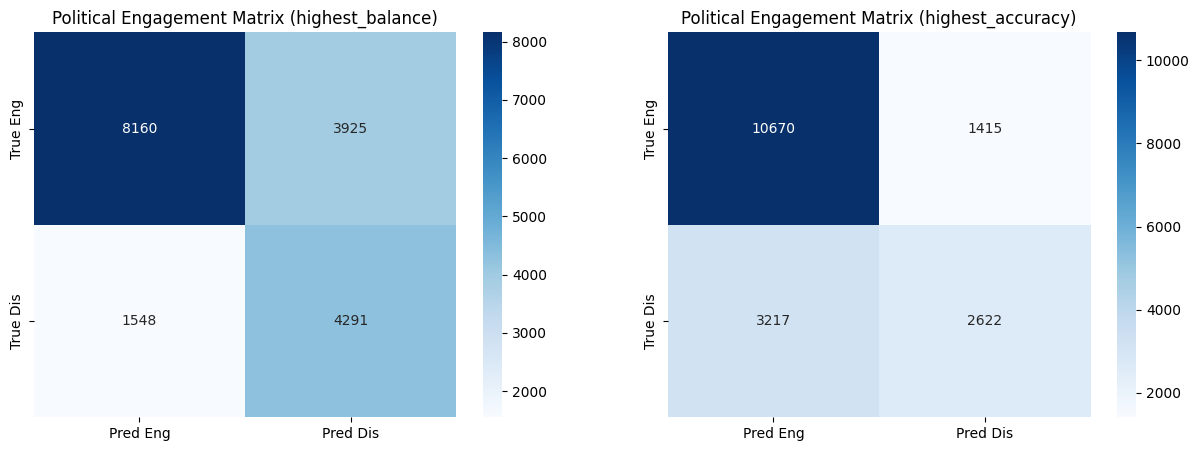

,threshold,accuracy_perc,precision_perc,sensitivity_perc
highest_balance,0.804,0.694655,52,73
highest_accuracy,0.899,0.742000,65,45


In [96]:
# get best thresholds
custom_functions.optimize_cm(y_test, ypred)

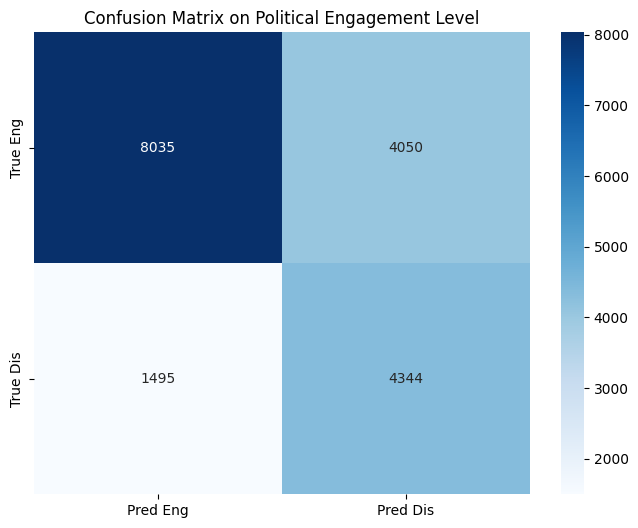

Estimates for threshold: 0.799
Model Accuracy:  0.69%
Correctly predicted political engagement levels (precison) : 52%
Overall proportion of correctly identified profiles (sensitivity) : 74%


In [97]:
# overall, despite XGBoost providing the best output, 
# the model's performance in terms of classification leaves much to be desired 
# since our objective is to discriminate politically disengaged people,
# the best model appears to be the one that maximizes the tpr / fpr rate (highest_balance)
# it identifies most of the politically disengaged people but also suffers from 
# a high false positive rate
# in a way we're lucky, since most of the participants are moderatly engaged, which
# could also inderectly benefit from an intervention attempting to rectify political engagement
# despite several attempts at improving the model (re-sampeling, weighting, different algorithms...)
# i don't believe the model would justify the ressources spent in intervening on false positives

# final choice: highest_balance classification with 52% precision and 74% sensitivity
custom_functions.get_cm(y_test, ypred, threshold=0.799)

### Results Intepretation
___

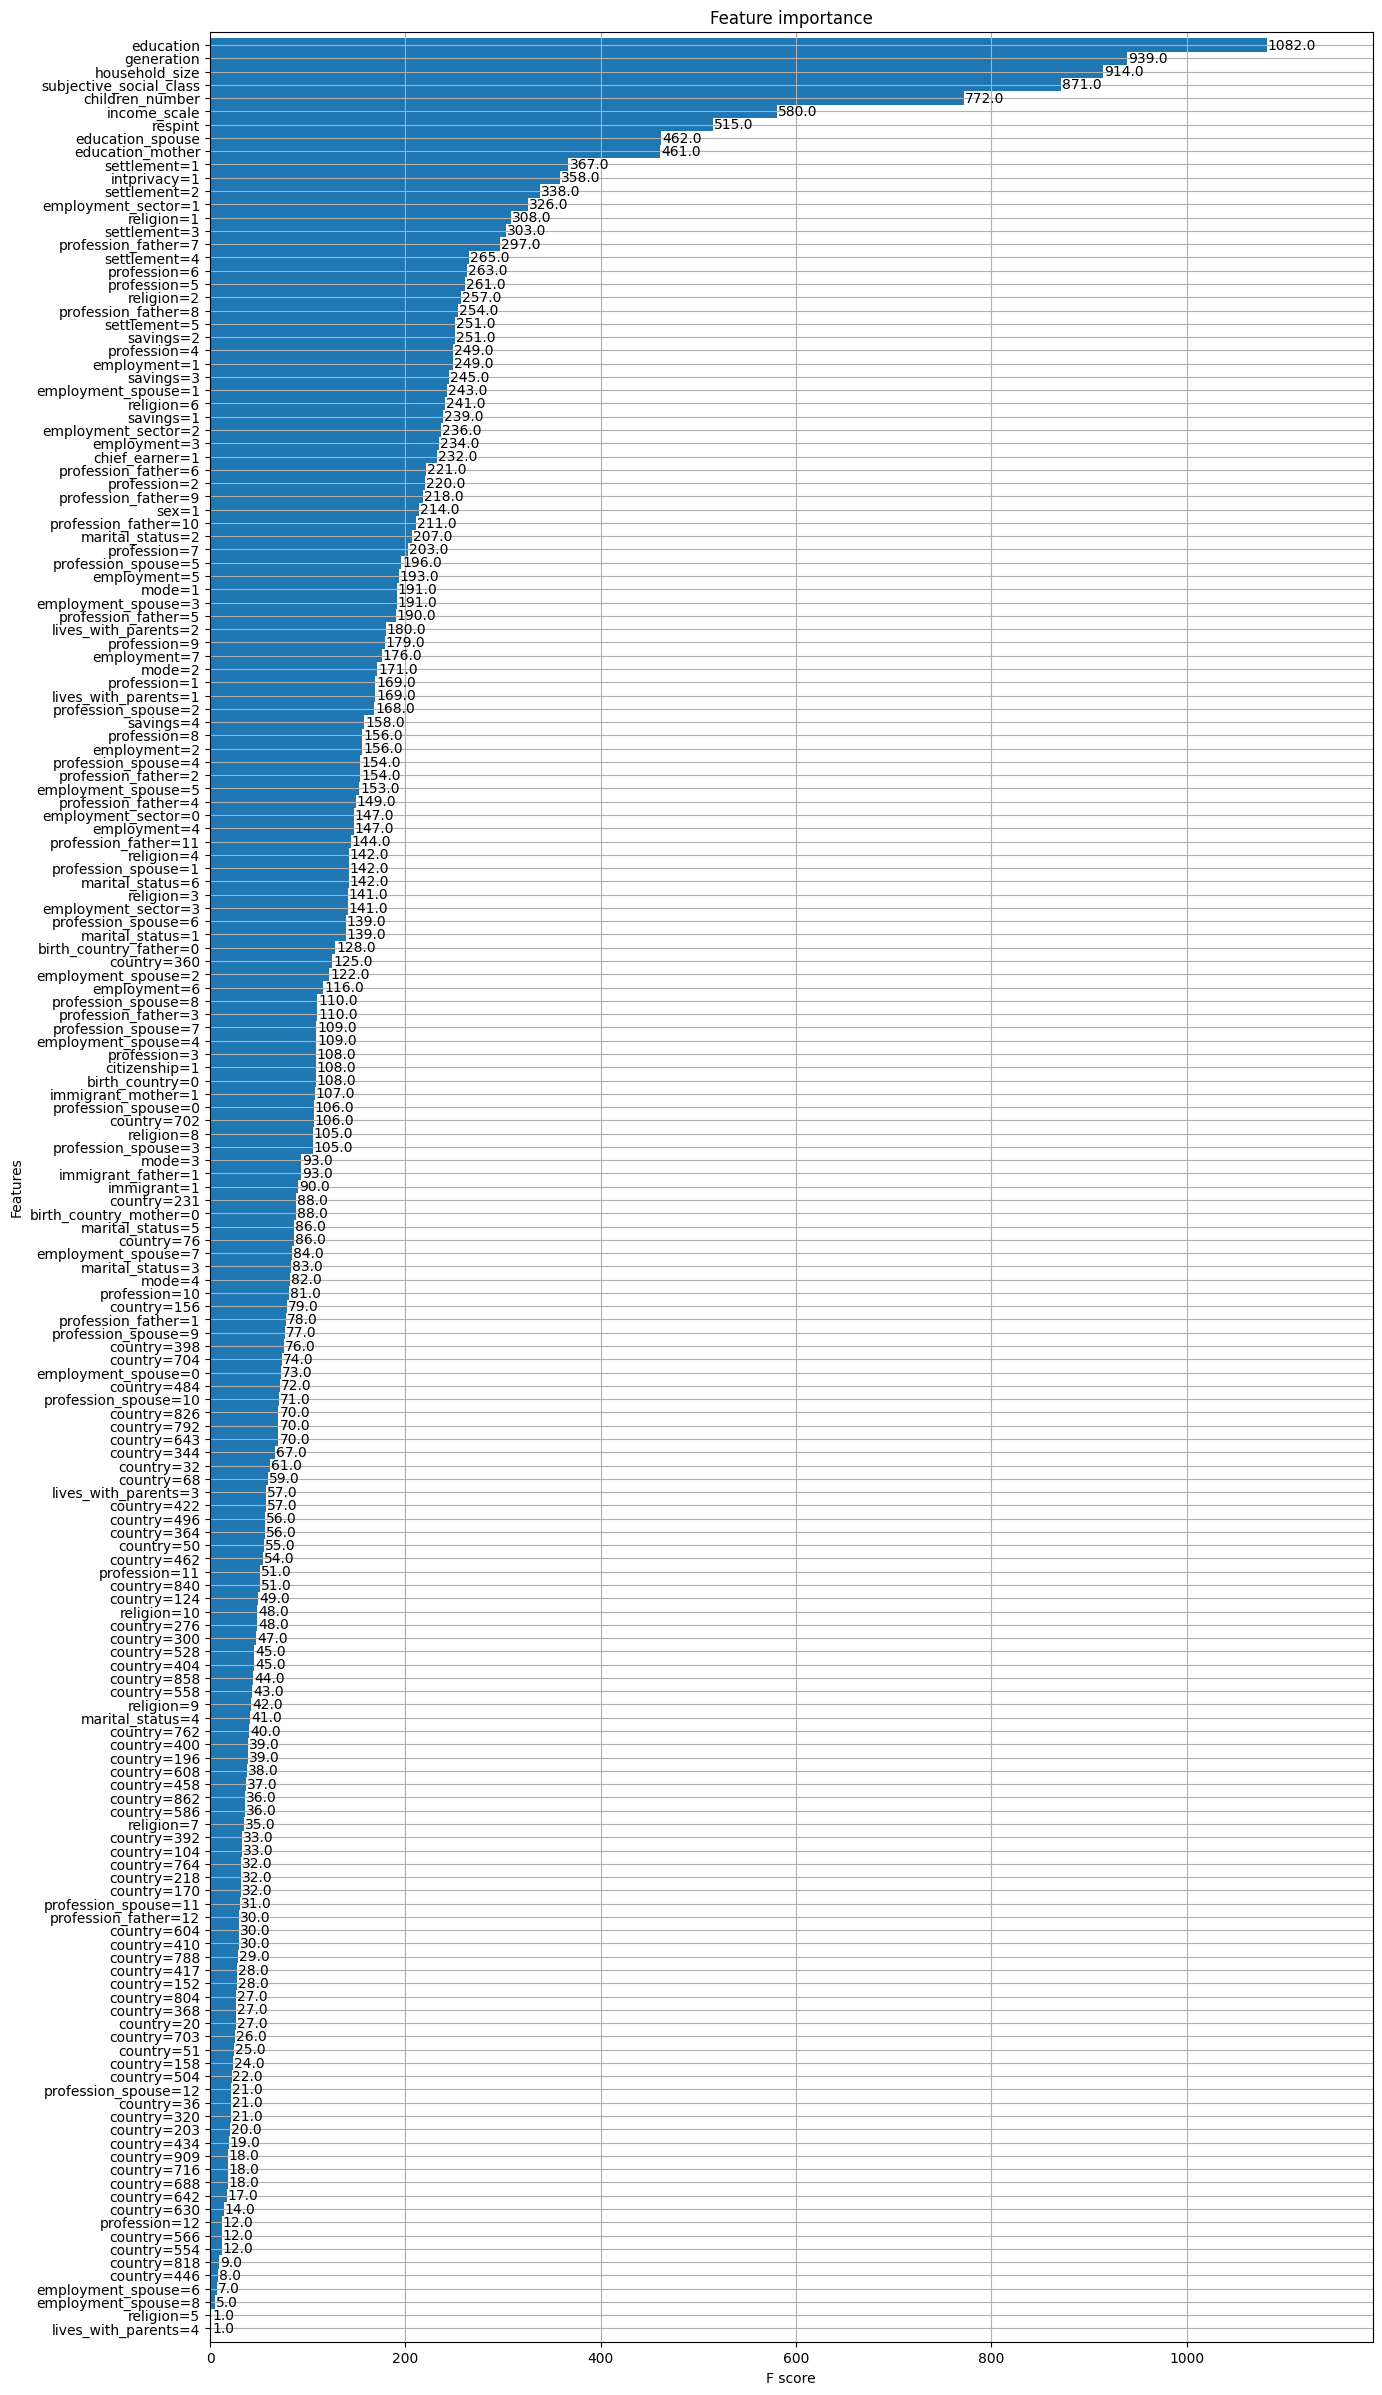

In [98]:
# examine feature importance
fig, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(xgb_model, ax=ax, height=1,)
plt.show()

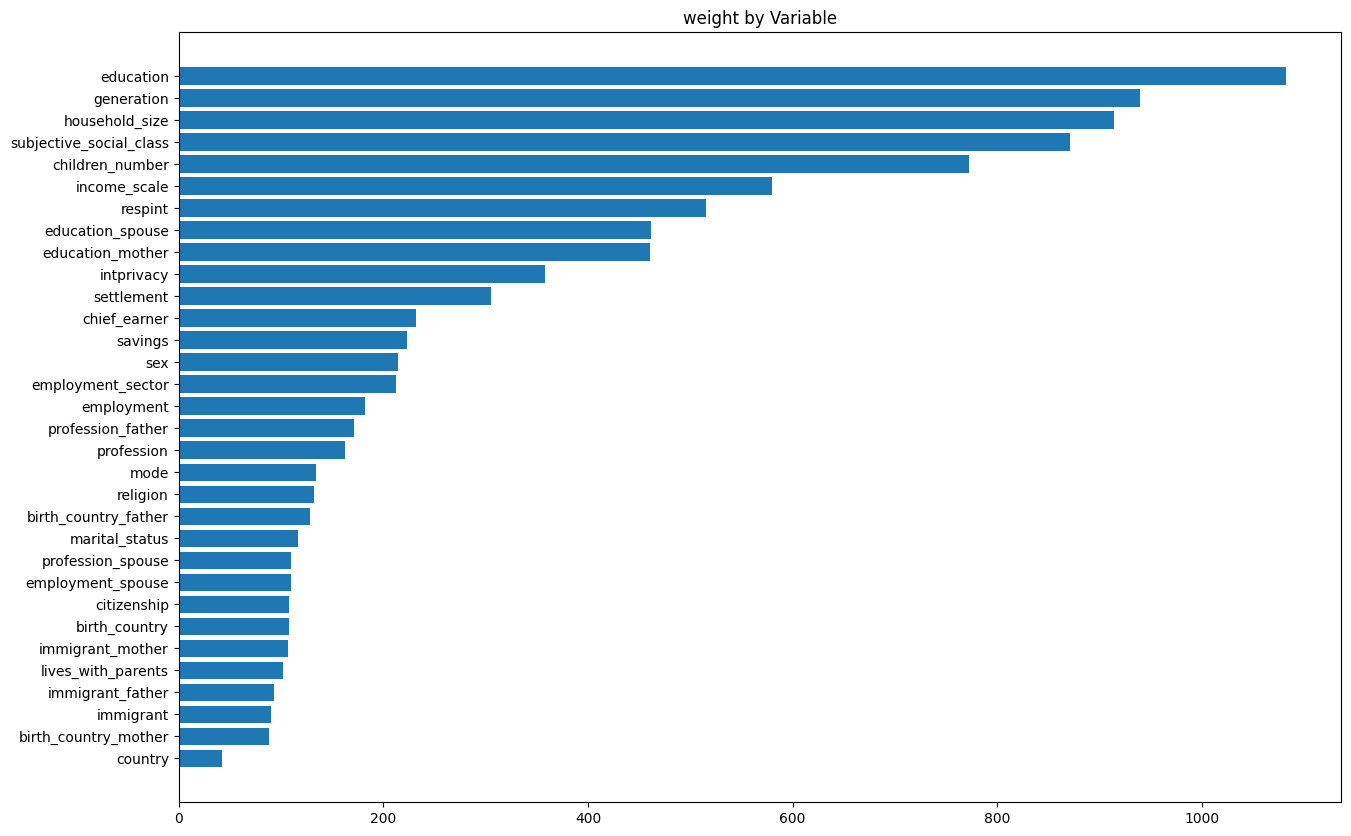

In [99]:
# examine model metrics
# weight = the number of times a feature appears in trees
# gain = average gain of the feature when it is used in tree
# cover = average coverage (number of samples affected) of the feature when it's used in trees
cols = [col for col in df_fulltrain if col != "political_engagement"]

# check which variables have been used in most splits
custom_functions.get_xgboost_metric(xgb_model, "weight", cols)

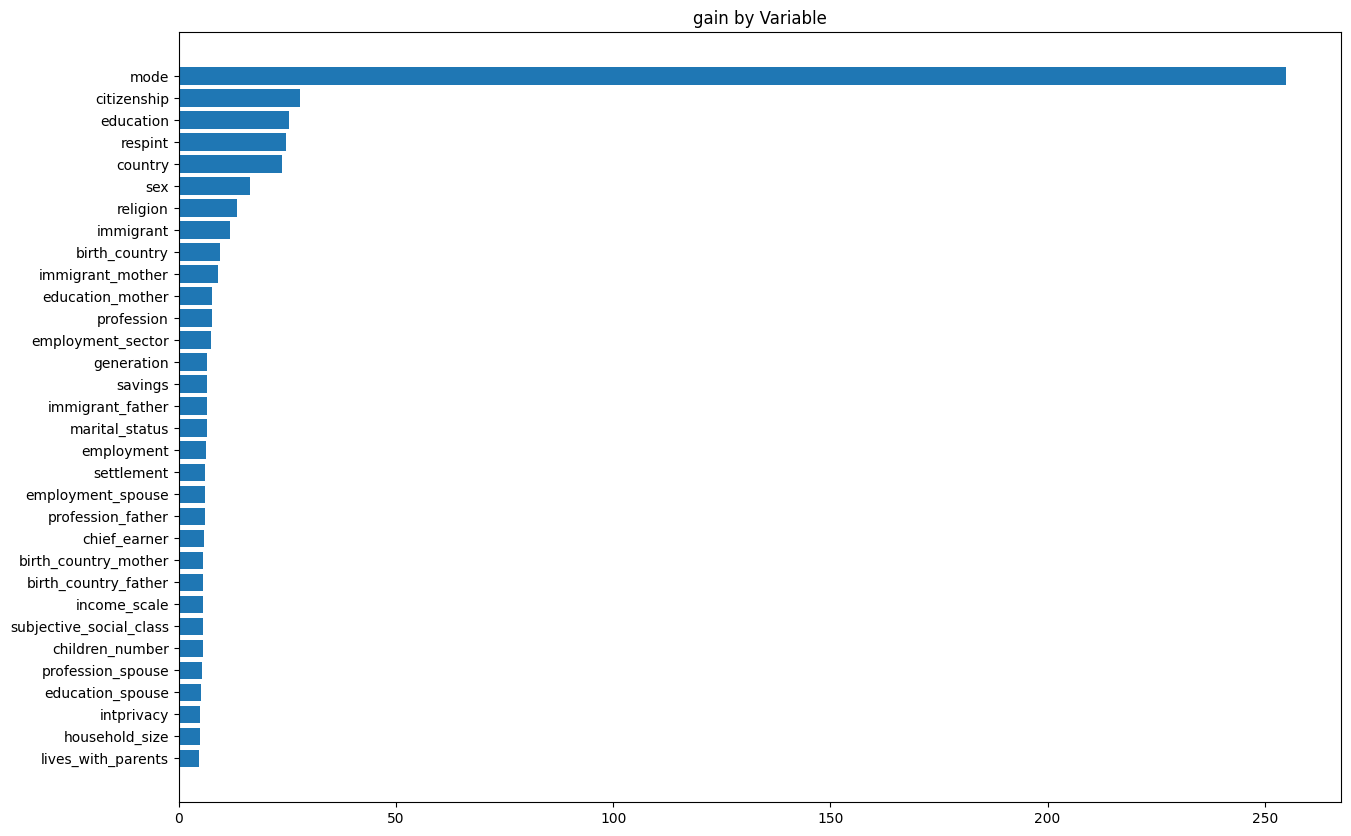

In [100]:
# check which feature in average most improved our accuracy accross splits
custom_functions.get_xgboost_metric(xgb_model, "gain", cols)

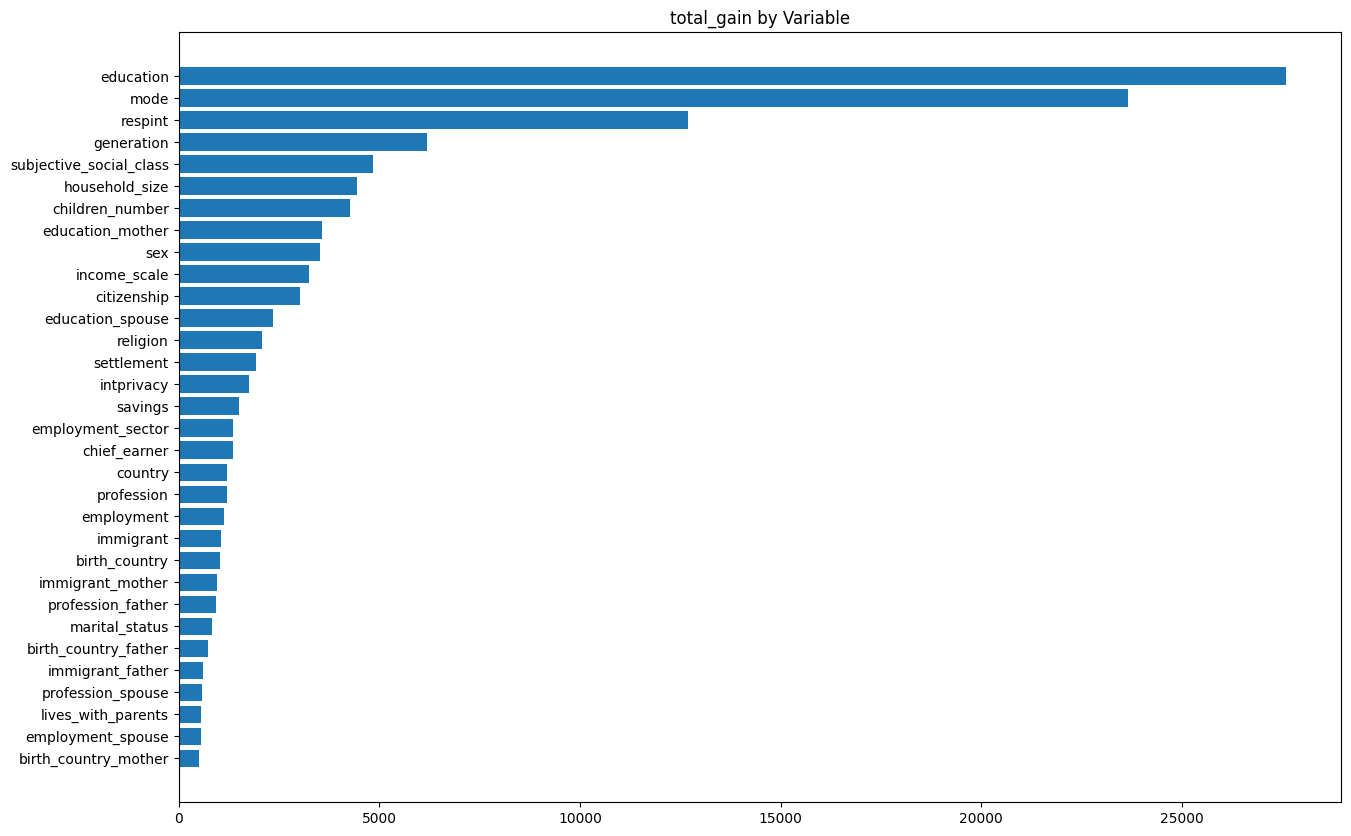

In [101]:
# check which feature overall improved our accuracy 
custom_functions.get_xgboost_metric(xgb_model, "total_gain", cols)

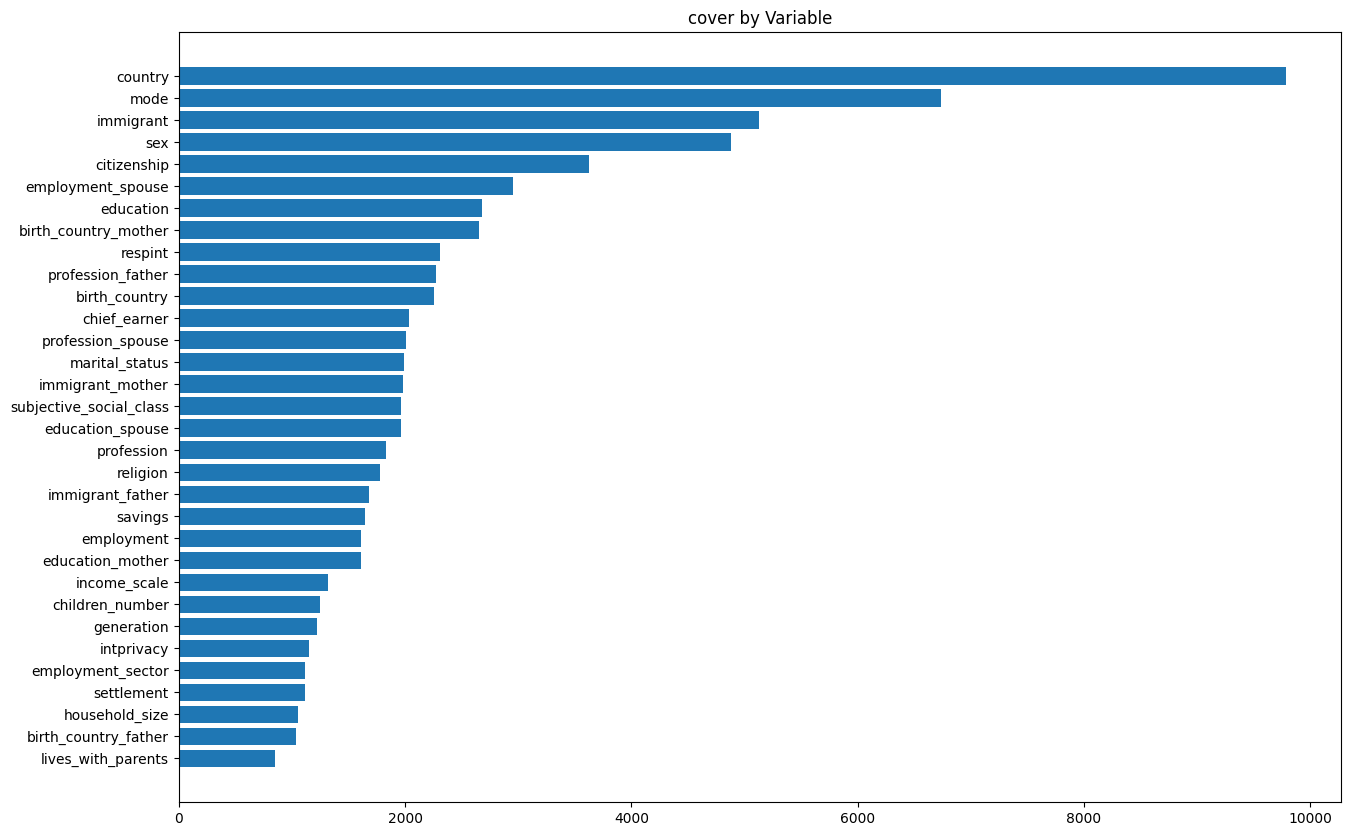

In [102]:
# check which feature in average had the most impact on the data accross splits
custom_functions.get_xgboost_metric(xgb_model, "cover", cols)

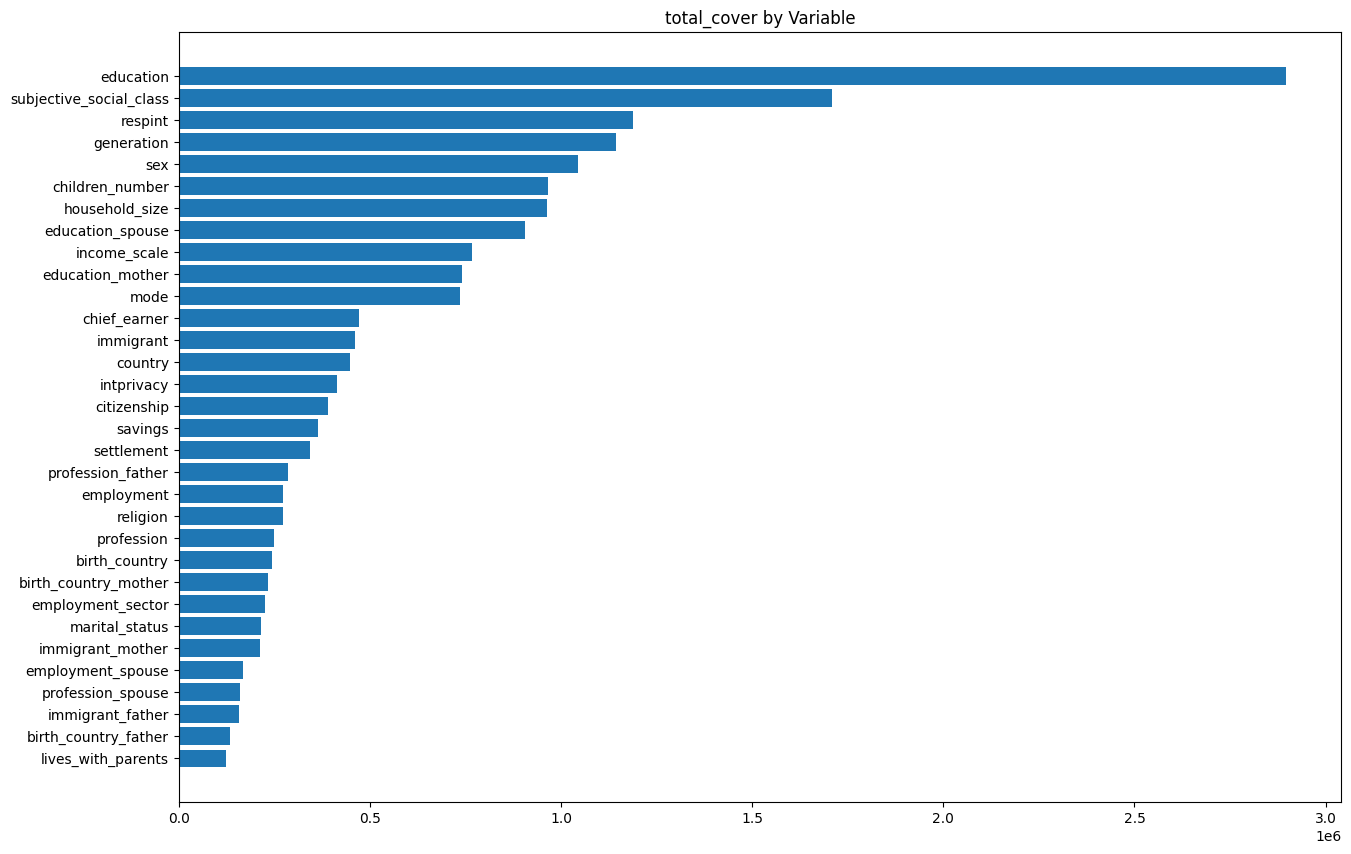

In [103]:
# check which feature overall had the most impact on the data accross splits
custom_functions.get_xgboost_metric(xgb_model, "total_cover", cols)

In [104]:
# The most used and best features to discriminate between the splits are education, 
# generation, household size and subjective social status, indicating their usefulness in partitioning the data.

# Surprisingly, mode (the modality of the interview) is one of the strongest predictors: 
# The World Value Survey has been administered via several modalities (computer, pen & paper, mail...)
# mixing a solo setting (person completing the survey by themselves) or social setting (assisted by an interviewer)...
# It wouldn't be hard to imagine someone reporting different levels of political engagement,
# based on the presence or not of peers (social desirability bias).
# In the same vein, the respondent's interest seems to also be a strong predictor of political engagement:
# I'd consider this a confounding factor that would need additional attention (we attempt to measure engagement, not motivation).
# Other strong predictors of political engagement seem to adhere to the current research consensus (education, generation, social class...).

# On the other hand, allocentric variable suggest mixed results:
# mother's education influences political engagement whereas the spouse's profession doesn't  

# Finally, although not frequent or predictive enough, country seem to have a high coverage score. 
# Additional analyses would help clarify its role (confounding variable, mediator)

# Since the scope of this project is primarly the application of a ML model, tuning &
# deployment, we ignored additional optimization and interpretation steps.